In [1]:
%%capture
#from jupyterthemes import jtplot
#jtplot.style()
import numpy as np
import operator
import seaborn as sns; sns.set()
from landlab import FieldError
from landlab.utils import get_watershed_mask
import xarray as xr
import pandas as pd
import scipy
import gdal
from scipy import ndimage
from scipy.ndimage.filters import *
import os
import math
from osgeo import osr
from fractions import Fraction
import timeit
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
#import matplotlib.image as mpimg
%matplotlib inline
import random
# import plotting tools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib as mpl
from landlab.plot.imshow import imshow_grid 

# import necessary landlab components
from landlab import RasterModelGrid, HexModelGrid
from landlab.components import FlowAccumulator, LakeMapperBarnes, SinkFillerBarnes
from landlab.components import(FlowDirectorD8, 
                               FlowDirectorDINF, 
                               FlowDirectorMFD, 
                               FlowDirectorSteepest)
from landlab.components import DepressionFinderAndRouter
# import landlab plotting functionality
from landlab.plot.drainage_plot import drainage_plot
from pylab import show, figure
from scipy.ndimage import gaussian_filter
from statsmodels.formula.api import ols
from scipy.stats import t
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from landlab.utils.flow__distance import calculate_flow__distance
from landlab.utils import watershed
from scipy.odr import *

In [207]:
def rectangleWindow(m, n):
    """Takes a value for number of rows (m) and number of columns (n) such that
       m and n are both positive real numbers and creates a rectangle of 
       boolian 'True' values."""
    rectangle = np.ones((m, n), dtype=bool) 
    return rectangle
def PCTL(x):
    """This function only works as an inside function to generic_filter function below. This
       is because generic_filter will take a 2d array and reshape it into a 1d array. Without this 
       step the 'central_value' variable will be outside of the array dimensions. 
       x = input DEM and r = radius of search window """
    centroid = x[central_value]                        
    y = np.sum(x < centroid)/num_values#Count number of values greater than centroid value
    return y
def number_of_values(Window):
    """This funciton takes the shape function as an input and returns a number 
        of values present in the specified shape. 
        
        This can be different for a different window shape and to initialize
        requires the specification of the function for the given window type and 
        parameter values required for that input function.
        
        To initialize this function for shape == rectangle type 'number_of_values(rectangleWindow(m,n)) 
        where m and n are any positive real number as per the rectangleWindow function."""
    denominator = sum(sum(Window > 0))
    return denominator
def slopeWindow(DEM_slope, x_cellsize, y_cellsize):
    """This function implements slope calculation using the same algorithm
       as ARCGIS (Outlined on the page 'How Slope Works').
       This particular example of the function is written such that it
       will only work if called within the ndimage generic_filter (as the first input).
       This is because the index arguments for a-e are given for the 1d array created
       by the generic_filter function after extracting values from the 3,3 rectangle window.
       NOTE: THIS FUNCTION ONLY WORKS WITH A 3x3 RECTANGLE WINDOW."""
    a = DEM_slope[0]; b = DEM_slope[1]; c = DEM_slope[2]
    d = DEM_slope[3]; e = DEM_slope[4]; f = DEM_slope[5]
    g = DEM_slope[6]; h = DEM_slope[7]; i = DEM_slope[8]
    dzdx = ((c + (2*f) + i) - (a + (2*d) + g)) / (8 * x_cellsize)
    dzdy = ((g + (2*h) + i) - (a + (2*b) + c)) / (8 * y_cellsize)
    rise_run = np.sqrt(dzdx**2 + dzdy**2)
    slope_degrees = np.arctan(rise_run) * (180/math.pi)
    slope_percent = rise_run * 100
    #Can also ask it to return slope_degrees but askinh for both causes it to throw and error.
    return slope_percent
def slopeWindowDegrees(DEM, x_cellsize, y_cellsize):
    """This function implements slope calculation using the same algorithm
       as ARCGIS (Outlined on the page 'How Slope Works').
       This particular example of the function is written such that it
       will only work if called within the ndimage generic_filter (as the first input).
       This is because the index arguments for a-e are given for the 1d array created
       by the generic_filter function after extracting values from the 3,3 rectangle window.
       NOTE: THIS FUNCTION ONLY WORKS WITH A 3x3 RECTANGLE WINDOW."""
    a = DEM[0]; b = DEM[1]; c = DEM[2]
    d = DEM[3]; e = DEM[4]; f = DEM[5]
    g = DEM[6]; h = DEM[7]; i = DEM[8]
    dzdx = ((c + (2*f) + i) - (a + (2*d) + g)) / (8 * x_cellsize)
    dzdy = ((g + (2*h) + i) - (a + (2*b) + c)) / (8 * y_cellsize)
    rise_run = np.sqrt(dzdx**2 + dzdy**2)
    slope_degrees = np.arctan(rise_run) * (180/math.pi)
    slope_percent = rise_run * 100
    #Can also ask it to return slope_degrees but asking for both causes it to throw and error.
    return slope_degrees
def slopeWindowMperM(DEM, x_cellsize, y_cellsize):
    """This function implements slope calculation using the same algorithm
       as ARCGIS (Outlined on the page 'How Slope Works').
       This particular example of the function is written such that it
       will only work if called within the ndimage generic_filter (as the first input).
       This is because the index arguments for a-e are given for the 1d array created
       by the generic_filter function after extracting values from the 3,3 rectangle window.
       NOTE: THIS FUNCTION ONLY WORKS WITH A 3x3 RECTANGLE WINDOW."""
    a = DEM[0]; b = DEM[1]; c = DEM[2]
    d = DEM[3]; e = DEM[4]; f = DEM[5]
    g = DEM[6]; h = DEM[7]; i = DEM[8]
    dzdx = ((c + (2*f) + i) - (a + (2*d) + g)) / (8 * x_cellsize)
    dzdy = ((g + (2*h) + i) - (a + (2*b) + c)) / (8 * y_cellsize)
    rise_run = np.sqrt(dzdx**2 + dzdy**2)
    slope_degrees = np.arctan(rise_run) * (180/math.pi)
    slope_m_per_m = rise_run
    #Can also ask it to return slope_degrees but asking for both causes it to throw and error.
    return slope_m_per_m
def planCurvature(DEM, cellsize):
    """This process is taken from Change (2014, Introduction to Geographic Information
    systems, Page 284)."""
    Z1 = DEM[0]; Z2 = DEM[1]; Z3 = DEM[2]
    Z4 = DEM[3]; Z0 = DEM[4]; Z5 = DEM[5]
    Z6 = DEM[6]; Z7 = DEM[7]; Z8 = DEM[8]
    D = (((Z4 + Z5)/2) - Z0) / cellsize**2
    E = (((Z2 + Z7)/2) - Z0) / cellsize**2
    F = (Z3 - Z1 + Z6 - Z8)/ (4 * cellsize**2)
    G = (Z5 - Z4) / (2 * cellsize)
    H = (Z2 - Z7) / (2 * cellsize)
    plan_curvature = 2 * ((D*H**2 + E*G**2 - F*G*H) / (G**2 + H**2))
    return plan_curvature
def profileCurvature(DEM, cellsize):
    """This process is taken from Change (2014, Introduction to Geographic Information
       systems, Page 284)."""
    Z1 = DEM[0]; Z2 = DEM[1]; Z3 = DEM[2]
    Z4 = DEM[3]; Z0 = DEM[4]; Z5 = DEM[5]
    Z6 = DEM[6]; Z7 = DEM[7]; Z8 = DEM[8]
    D = (((Z4 + Z5)/2) - Z0) / cellsize**2
    E = (((Z2 + Z7)/2) - Z0) / cellsize**2
    F = (Z3 - Z1 + Z6 - Z8)/ (4 * cellsize**2)
    G = (Z5 - Z4) / (2 * cellsize)
    H = (Z2 - Z7) / (2 * cellsize)
    profile_curvature = -2 * (D*G**2 + E*H**2 + F*G*H) / (G**2 + H**2)
    return profile_curvature
def circleWindow(radius):
    """Takes a value for radius (r where r is any positive real number) and creates 
       a circular window using that radius."""
    y, x = np.ogrid[-radius: radius + 1, -radius: radius + 1]
    circle = x**2 + y**2 <= radius**2
    return circle
def find_median_value(Window):
    """This function takes the shape function and returns the median value 
        for all valid values (values that fall in the circle) arranged into a 
        1d array. The function also takes the number_of_values function as an input.
        To execute this function type 'find_median_value(shape(r)) where r is any integer.
        #Note: using median like this only gives the correct value for circles with odd 
        radius values."""
    no_values = number_of_values(Window)
    value_range = np.arange(0, no_values + 1)
    central_value = int(np.median(value_range))
    return central_value
def differenceFromMeanElevation(elev):
    """This function only works as an inside function to generic_filter function below. This
       is because generic_filter will take a 2d array and reshape it into a 1d array. Without this 
       step the 'central_value' variable will be outside of the array dimensions. 
       x = input DEM and r = radius of search window """
    centroid = elev[central_value]                        
    mean = np.nanmean(elev)#Count number of values greater than centroid value
    diff = centroid - mean
    return diff
def ghFilter(gully_heads):
    """Reduce the number of candidate initial gully heads. The window size is custimizable through the 
    'footprint' argument. """
    surrounding_nodes_list = [];
    for i in range(0, num_values):
        if i != central_value:
            surrounding_nodes_list.append(gully_heads[i])
    
    surrounding_nodes_array = np.array(surrounding_nodes_list)
    non_zero_values = surrounding_nodes_array[surrounding_nodes_array > 0]
    if non_zero_values.size == 0:
        new_value = 0  
    else:
        if gully_heads[central_value] > 0 and np.min(non_zero_values) > gully_heads[central_value]:
            new_value = 1
        else:
            new_value = 0

    return new_value
def roundup(x):
    return int(math.ceil(x / 10.0)) * 10
def catchmentDicts(area_grid, gn, gh_nodes):
    """Creates a dictionary of node ID:catcment area values."""
    area_dict = {}
    nodes = gh_nodes
    x_axis_length = gn.shape[1]
    for i in nodes:
        row = int(np.floor(i / x_axis_length))
        col = int(i - (row*x_axis_length))
        area = area_grid[row,col]
        area_dict[i] = area
    return area_dict
def upslopeDivergence(catchment_area_list, change_detection_factor, step_size, comparison_distance):
    
    """"Looks at whether catchment area is increasing at any point upstream of a gully head.
    
    - 'catchment_area_list' is an ordered list of node catchment areas moving upstream.
    
    - 'change_detection_factor' is the percentage increase required for the function to consider the change
    to represent a point of divergent flow.
    
    - 'step_size' is the number of grid cells to be compared in downstream to upstream groups. E.g. step_size == 1 
    will compare node 1 and node 2, but step_size == 2 will compare node 1 and 2 to node 3 and 4.
    
    - 'comparison_distance' is the distance between the downstream nodes being compared to upstream nodes."""
    
    max_value_length = len(catchment_area_list) - step_size - comparison_distance - step_size
    for i in range(0, max_value_length):
                
        start_of_downstream_nodes = i
        end_of_downstream_nodes = i + step_size       
        downstream_nodes = catchment_area_list[start_of_downstream_nodes:end_of_downstream_nodes]
        
        start_of_upstream_nodes = i + step_size + comparison_distance
        end_of_usptreat_nodes = start_of_upstream_nodes + step_size
        upstream_nodes = catchment_area_list[start_of_upstream_nodes:end_of_usptreat_nodes]
        
        required_catchment_area_increase = max(downstream_nodes) + (max(downstream_nodes) * change_detection_factor)
        
        if all(nodes >= required_catchment_area_increase for nodes in upstream_nodes):
            divergence = 1
            break
        else:
            divergence = 0
    return divergence
def findGullyHeadNode(gully_heads, grid_nodes, DEM, ca, input_DEM_resolution, 
                      distance_from_node, contributing_fraction, required_ca):
    
    catchment_area_dict = {}
    catchment_area_node_list = []
    distance_from_node = int(np.ceil(distance_from_node/input_DEM_resolution))

    for i in gully_heads:

        result = np.where(grid_nodes == i)
        #################################################################################################
        # Find the index position (in the whole DEM) that corresponds to the current gully head point in the list.
        row_index = result[0][0];
        col_index = result[1][0];
        #################################################################################################
        # Create a subset based on above. Plus 1 to bottom abnd right so that the currenmmt gully ead node is always the 
        # centraL grid node of the subset.
        subset_row_top = int(row_index - distance_from_node)
        subset_row_bot = int(row_index + distance_from_node) + 1
        subset_col_left = int(col_index - distance_from_node)
        subset_col_right = int(col_index + distance_from_node) + 1
        #################################################################################################
        # Restrict the size of the subset in cases where it is on the edge of a DEM.
        subset_row_top_adjusted = max(subset_row_top, 0);
        subset_row_bot_adjusted = min(subset_row_bot, DEM.shape[0]);
        subset_col_left_adjusted = max(subset_col_left, 0);
        subset_col_right_adjusted = min(subset_col_right, DEM.shape[1]);
        #################################################################################################
        # Find the offset required by restricting the size of the subset around DEM edges.
        # This offset is needed to find the new location of the current gully head grid cell (no longer center of the subset).
        offset_row_top = int(np.sqrt((subset_row_top - subset_row_top_adjusted)**2)) * -1;
        offset_row_bot = int(np.sqrt((subset_row_bot - subset_row_bot_adjusted)**2));
        offset_col_left = int(np.sqrt((subset_col_left - subset_col_left_adjusted)**2)) * -1;
        offset_col_right = int(np.sqrt((subset_col_right - subset_col_right_adjusted)**2));
        #################################################################################################
        # Create subset around the current gully head grid node. 
        dem_subset = DEM[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                     subset_col_left_adjusted:subset_col_right_adjusted]

        #################################################################################################
        ca_subset = ca[subset_row_top_adjusted:subset_row_bot_adjusted, 
                             subset_col_left_adjusted:subset_col_right_adjusted]
        print('max ca: ', np.amax(ca_subset))
        #################################################################################################
        # Find the latitude and longitude index positions of the gully head node in the subset DEM.
        node_lat = distance_from_node + offset_row_top
        node_lon = distance_from_node + offset_col_left
        #################################################################################################  
        # Run M8 for the subset DEM.
        flow_acc_surf_sub = np.copy(dem_subset).astype('float64');

        rows_sub = flow_acc_surf_sub.shape[0];
        cols_sub = flow_acc_surf_sub.shape[1];
        mg1 = RasterModelGrid((rows_sub,cols_sub), 1);
        z1 = mg1.add_field('topographic__elevation', flow_acc_surf_sub, at = 'node');
        sfb = SinkFillerBarnes(mg1, method = 'Steepest', ignore_overfill = True);
        sfb.run_one_step();
        fa = FlowAccumulator(mg1,
                            surface = 'topographic__elevation',
                            flow_director = 'FlowDirectorMFD',
                            diagonals = True);
        fa.run_one_step()
        fd = FlowDirectorMFD(mg1, 'topographic__elevation', diagonals = True);
        fd.run_one_step()
        #################################################################################################
        # Extract required grid properties
        da = np.array(mg1.at_node['drainage_area'].round(4)); # Drainage area.
        frn = mg1.at_node['flow__receiver_node'];# Flow receiver nodes.
        drainage_area = da.reshape(mg1.shape);
        frp = np.array(mg1.at_node['flow__receiver_proportions']);# Flow receiver proportions
        flow_rec_surf_rows = cols_sub * rows_sub;
        flow_rec_surf = frp.reshape(flow_rec_surf_rows,8);
        all_receiver_proportions = np.copy(frp);
        grid_nodes_sub = np.array(mg1.nodes.reshape(mg1.shape));
        #################################################################################################
        central_node = grid_nodes_sub[node_lat, node_lon]
        # Specific the size of the area to be checked. This represents a physical distance from the 
        # outlet but has no unit of measure. Its maximum size is the size of the 'distance_from_node' variable.

        # This value is used to initialise the search.
        catchment_outlet_id = central_node

        # Initate an outer loop that iterates through every distance interval from the outlet. Each iteration checks whether 
        # an area equal to the 'contributing_fraction' variable below is being directed in only one direction (converging).
        # Otherwise it moves to the nect grid cell downslope in the direction of steepest slope.

        # Create a grid of node value sfor the subset DEM.
        node_location = mg1.nodes.reshape(da.shape);
        for j in range(0, distance_from_node):
            # Begin at the point (node) digitized as the intersection between the central flow line and the gully head.
            if j == 0:
                candidate_gridcell = catchment_outlet_id;
            else:
                candidate_gridcell = next_cell_downstream;
            # Get all receiver nodes of the current node.
            grid_cell_receiver_nodes = frp[candidate_gridcell,:];
            # Check if there is a node that receives >= 'contributing_fraction' from the current node.
            candidate_gridcell_list = [candidate_gridcell]
            node_ca_int = catchmentDicts(ca_subset, grid_nodes_sub, candidate_gridcell_list) # Find the node's contributing area.
            node_ca = node_ca_int[candidate_gridcell]
            print('Node id: ', candidate_gridcell, 'Catchment area: ', node_ca)
            if np.amax(grid_cell_receiver_nodes) < contributing_fraction or node_ca < required_ca:
                # Check if this is the last possible grid cell in the subset that could meet the criteria. If so, then there
                # is no suitable grid cell (node).
                if j == distance_from_node - 1:
                    catchment_area_dict[i] = 'No grid cell found'
                else:
                    # Otherwise, find the next downslope grid cell receiving the highest proportion of flow and check that 
                    # in the next iteration.
                    index_next_cell_downstream = np.where(grid_cell_receiver_nodes == np.amax(grid_cell_receiver_nodes))[0][0];
                    next_cell_downstream = frn[candidate_gridcell, index_next_cell_downstream];
            else:
                # Find the position of the gridcell (node) that meets the criteria both in the subset and in the whole DEM
                # and record the node ID.
                final_node_index_lat =  np.where(grid_nodes_sub == candidate_gridcell)[0][0]
                final_node_index_lon =  np.where(grid_nodes_sub == candidate_gridcell)[1][0]
                
                # Find the offest between the index position of the node the loop ends on, and the index position of
                # the node that it started on. 
                final_lat_offset = final_node_index_lat - node_lat
                final_lon_offset = final_node_index_lon - node_lon
                # Then apply this offest to the index position of the starting node with respect top the whole DEM to find the 
                # node ID of the grid cell that met the criteria above.
                final_row_index = row_index + final_lat_offset
                final_col_index = col_index + final_lon_offset
                node_of_area_record = grid_nodes[final_row_index, final_col_index] # - this range is more than 1
                catchment_area_dict[i] = node_of_area_record
                catchment_area_node_list.append(node_of_area_record)
                break
                             
    return catchment_area_dict, catchment_area_node_list
def findPoint5mDownstream(gully_heads, grid_nodes, DEM, ca, input_DEM_resolution, 
                      distance_from_node):
    
    catchment_area_dict = {}
    catchment_area_node_list = []
    distance_from_node = int(np.ceil(distance_from_node/input_DEM_resolution))

    for i in gully_heads:

        result = np.where(grid_nodes == i)
        #################################################################################################
        # Find the index position (in the whole DEM) that corresponds to the current gully head point in the list.
        row_index = result[0][0];
        col_index = result[1][0];
        #################################################################################################
        # Create a subset based on above. Plus 1 to bottom abnd right so that the currenmmt gully ead node is always the 
        # centraL grid node of the subset.
        subset_row_top = int(row_index - distance_from_node)
        subset_row_bot = int(row_index + distance_from_node) + 1
        subset_col_left = int(col_index - distance_from_node)
        subset_col_right = int(col_index + distance_from_node) + 1
        #################################################################################################
        # Restrict the size of the subset in cases where it is on the edge of a DEM.
        subset_row_top_adjusted = max(subset_row_top, 0);
        subset_row_bot_adjusted = min(subset_row_bot, DEM.shape[0]);
        subset_col_left_adjusted = max(subset_col_left, 0);
        subset_col_right_adjusted = min(subset_col_right, DEM.shape[1]);
        #################################################################################################
        # Find the offset required by restricting the size of the subset around DEM edges.
        # This offset is needed to find the new location of the current gully head grid cell (no longer center of the subset).
        offset_row_top = int(np.sqrt((subset_row_top - subset_row_top_adjusted)**2)) * -1;
        offset_row_bot = int(np.sqrt((subset_row_bot - subset_row_bot_adjusted)**2));
        offset_col_left = int(np.sqrt((subset_col_left - subset_col_left_adjusted)**2)) * -1;
        offset_col_right = int(np.sqrt((subset_col_right - subset_col_right_adjusted)**2));
        #################################################################################################
        # Create subset around the current gully head grid node. 
        dem_subset = DEM[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                     subset_col_left_adjusted:subset_col_right_adjusted]

        #################################################################################################
        ca_subset = ca[subset_row_top_adjusted:subset_row_bot_adjusted, 
                             subset_col_left_adjusted:subset_col_right_adjusted]
        print('max ca: ', np.amax(ca_subset))
        #################################################################################################
        # Find the latitude and longitude index positions of the gully head node in the subset DEM.
        node_lat = distance_from_node + offset_row_top
        node_lon = distance_from_node + offset_col_left
        #################################################################################################  
        # Run M8 for the subset DEM.
        flow_acc_surf_sub = np.copy(dem_subset).astype('float64');

        rows_sub = flow_acc_surf_sub.shape[0];
        cols_sub = flow_acc_surf_sub.shape[1];
        mg1 = RasterModelGrid((rows_sub,cols_sub), 1);
        z1 = mg1.add_field('topographic__elevation', flow_acc_surf_sub, at = 'node');
        sfb = SinkFillerBarnes(mg1, method = 'Steepest', ignore_overfill = True);
        sfb.run_one_step();
        fa = FlowAccumulator(mg1,
                            surface = 'topographic__elevation',
                            flow_director = 'FlowDirectorMFD',
                            diagonals = True);
        fa.run_one_step()
        fd = FlowDirectorMFD(mg1, 'topographic__elevation', diagonals = True);
        fd.run_one_step()
        #################################################################################################
        # Extract required grid properties
        da = np.array(mg1.at_node['drainage_area'].round(4)); # Drainage area.
        frn = mg1.at_node['flow__receiver_node'];# Flow receiver nodes.
        drainage_area = da.reshape(mg1.shape);
        frp = np.array(mg1.at_node['flow__receiver_proportions']);# Flow receiver proportions
        flow_rec_surf_rows = cols_sub * rows_sub;
        flow_rec_surf = frp.reshape(flow_rec_surf_rows,8);
        all_receiver_proportions = np.copy(frp);
        grid_nodes_sub = np.array(mg1.nodes.reshape(mg1.shape));
        #################################################################################################
        central_node = grid_nodes_sub[node_lat, node_lon]
        # Specific the size of the area to be checked. This represents a physical distance from the 
        # outlet but has no unit of measure. Its maximum size is the size of the 'distance_from_node' variable.

        # This value is used to initialise the search.
        catchment_outlet_id = central_node

        # Initate an outer loop that iterates through every distance interval from the outlet. Each iteration checks whether 
        # an area equal to the 'contributing_fraction' variable below is being directed in only one direction (converging).
        # Otherwise it moves to the nect grid cell downslope in the direction of steepest slope.

        # Create a grid of node value sfor the subset DEM.
        node_location = mg1.nodes.reshape(da.shape);
        for j in range(0, distance_from_node):
            # Begin at the point (node) digitized as the intersection between the central flow line and the gully head.
            if j == 0:
                candidate_gridcell = catchment_outlet_id;
            else:
                candidate_gridcell = next_cell_downstream;
            # Get all receiver nodes of the current node.
            grid_cell_receiver_nodes = frp[candidate_gridcell,:];
            # Check if there is a node that receives >= 'contributing_fraction' from the current node.
            candidate_gridcell_list = [candidate_gridcell]
            node_ca_int = catchmentDicts(ca_subset, grid_nodes_sub, candidate_gridcell_list) # Find the node's contributing area.
            node_ca = node_ca_int[candidate_gridcell]
            print('Node id: ', candidate_gridcell, 'Catchment area: ', node_ca)
            if j + 1 < distance_from_node:
                
                # Otherwise, find the next downslope grid cell receiving the highest proportion of flow and check that 
                # in the next iteration.
                index_next_cell_downstream = np.where(grid_cell_receiver_nodes == np.amax(grid_cell_receiver_nodes))[0][0];
                next_cell_downstream = frn[candidate_gridcell, index_next_cell_downstream];
            else:
                print(j)
                # Find the position of the gridcell (node) that meets the criteria both in the subset and in the whole DEM
                # and record the node ID.
                final_node_index_lat =  np.where(grid_nodes_sub == candidate_gridcell)[0][0]
                final_node_index_lon =  np.where(grid_nodes_sub == candidate_gridcell)[1][0]
                
                # Find the offest between the index position of the node the loop ends on, and the index position of
                # the node that it started on. 
                final_lat_offset = final_node_index_lat - node_lat
                final_lon_offset = final_node_index_lon - node_lon
                # Then apply this offest to the index position of the starting node with respect top the whole DEM to find the 
                # node ID of the grid cell that met the criteria above.
                final_row_index = row_index + final_lat_offset
                final_col_index = col_index + final_lon_offset
                node_of_area_record = grid_nodes[final_row_index, final_col_index] # - this range is more than 1
                catchment_area_dict[i] = node_of_area_record
                catchment_area_node_list.append(node_of_area_record)
                break
                             
    return catchment_area_dict, catchment_area_node_list
def closest(lst, K): 
     angle_list = lst
     index_pos = (np.abs(angle_list - K)).argmin() 
     return angle_list[index_pos]  
def data_range(data):
    data_min = np.amin(data); data_max = np.amax(data)
    value_range = data_max - data_min
    return value_range
def checkGullyHead(dfme_list, step_size, comparison_distance, minimum_depth, elevation_of_gh):
    
    """ """
    max_value_length = len(dfme_list) - step_size - comparison_distance - step_size
    for i in range(0, max_value_length):
                
        start_of_downstream_nodes = i
        end_of_downstream_nodes = i + step_size       
        downstream_nodes = dfme_list[start_of_downstream_nodes:end_of_downstream_nodes]
        
        start_of_upstream_nodes = i + step_size + comparison_distance
        end_of_usptreat_nodes = start_of_upstream_nodes + step_size
        upstream_nodes = dfme_list[start_of_upstream_nodes:end_of_usptreat_nodes]
        
        min_downstream = np.min(downstream_nodes)
        mean_upstream = np.mean(upstream_nodes)
        std_upstream = np.std(upstream_nodes)
        elevation_difference = min_downstream - mean_upstream
        print('minimum downstream value: ', min_downstream)
        print('mean upstream value: ', mean_upstream)
        print('std upstream value: ', std_upstream)
      
        if min_downstream <= minimum_depth and mean_upstream > elevation_of_gh and std_upstream < 0.1 and elevation_difference <= -0.2:
            keep_gully = 'yes'
            # below could use either floor or ceil instead of round 
            gully_head_location = int(end_of_downstream_nodes + np.round(comparison_distance/2))
            break
        else:
            keep_gully = 'no'
            gully_head_location = 'none'

    return keep_gully, gully_head_location
def checkGullyHeadElev(dfme_list, elev_list, step_size, comparison_distance, minimum_depth, elevation_of_gh, height_change):
    
    """ """
    max_value_length = len(dfme_list) - step_size - comparison_distance - step_size
    for i in range(0, max_value_length):
                
        start_of_downstream_nodes = i
        end_of_downstream_nodes = i + step_size       
        downstream_nodes = dfme_list[start_of_downstream_nodes:end_of_downstream_nodes]
        
        start_of_upstream_nodes = i + step_size + comparison_distance
        end_of_upstream_nodes = start_of_upstream_nodes + step_size
        upstream_nodes = dfme_list[start_of_upstream_nodes:end_of_upstream_nodes]
        
        #min_downstream = np.min(downstream_nodes)
        min_downstream = np.max(downstream_nodes)
        mean_upstream = np.mean(upstream_nodes)
        std_upstream = np.std(upstream_nodes)
        #std_upstream = np.std(elev_list[start_of_upstream_nodes:end_of_upstream_nodes])
        elevation_difference = np.median(elev_list[start_of_upstream_nodes:end_of_upstream_nodes]) - np.median(elev_list[start_of_downstream_nodes:end_of_downstream_nodes])
        print('minimum downstream value: ', min_downstream)
        print('mean upstream value: ', mean_upstream)
        print('std upstream value: ', std_upstream)
      
        if min_downstream <= minimum_depth and mean_upstream > elevation_of_gh and std_upstream < 0.1 and elevation_difference >= height_change:
            keep_gully = 'yes'
            # below could use either floor or ceil instead of round 
            gully_head_location = int(end_of_downstream_nodes + np.round(comparison_distance/2))
            break
        else:
            keep_gully = 'no'
            gully_head_location = 'none'

    return keep_gully, gully_head_location
def upstreamDrainageLine(meters_from_gully_head, input_DEM_resolution, grid_nodes, DEM, import_drainage_area, 
                         import_dfme, catchment_outlet_ids, step_size_m, comparison_distance_m,  
                         min_depth, gh_elevation):
    
    """This function works its way up the hillslope from a gully head recording 
    catchment area at each grid cell along the way. Then for each gully head it assesses whether divergence is occuring 
    at any point by using the upslopeDivergence function.
    
    meters_from_gully_head == distance upstream from gully head in meters.
    input_DEM_resolution == grid resolution of the input DEM.
    frn == flow receiver nodes stored on the model grid object.
    catchment_outlet_ids == a list of grid cells found using the estimateCatchmentArea function.
    drainage_area == drainage area stored on the model grid object.
    grid_nodes == grid node values stored on the model grid object.
    DEM == initial input_DEM
    step_size_m and comparison_distance_m are both enetered in meters and are then adjusted automatically
    to fit the resolution.
    slope_above_head == the distance from the convergence point that slope is taken."""
    
    final_gully_head_position_dict = {}
    catchment_area_node_list = []
    distance_from_node = int(meters_from_gully_head / input_DEM_resolution)
    is_gully_head = {}

    step_size = int(np.round(step_size_m / input_DEM_resolution))
    comparison_distance = int(np.round(comparison_distance_m / input_DEM_resolution))
    gully_head_node_dict = {}
    for i in catchment_outlet_ids:
        
        result = np.where(grid_nodes == i)
        #################################################################################################
        # Find the index position (in the whole DEM) that corresponds to the current gully head point in the list.
        row_index = result[0][0];
        col_index = result[1][0];
        #################################################################################################
        # Create a subset based on above. Plus 1 to bottom abnd right so that the currenmmt gully ead node is always the 
        # centraL grid node of the subset.
        subset_row_top = int(row_index - distance_from_node)
        subset_row_bot = int(row_index + distance_from_node) + 1
        subset_col_left = int(col_index - distance_from_node)
        subset_col_right = int(col_index + distance_from_node) + 1
        #################################################################################################
        # Restrict the size of the subset in cases where it is on the edge of a DEM.
        subset_row_top_adjusted = max(subset_row_top, 0);
        subset_row_bot_adjusted = min(subset_row_bot, DEM.shape[0]);
        subset_col_left_adjusted = max(subset_col_left, 0);
        subset_col_right_adjusted = min(subset_col_right, DEM.shape[1]);
        #################################################################################################
        # Find the offset required by restricting the size of the subset around DEM edges.
        # This offset is needed to find the new location of the current gully head grid cell (no longer center of the subset).
        offset_row_top = int(np.sqrt((subset_row_top - subset_row_top_adjusted)**2)) * -1;
        offset_row_bot = int(np.sqrt((subset_row_bot - subset_row_bot_adjusted)**2));
        offset_col_left = int(np.sqrt((subset_col_left - subset_col_left_adjusted)**2)) * -1;
        offset_col_right = int(np.sqrt((subset_col_right - subset_col_right_adjusted)**2));
        #################################################################################################
        # Create subset around the current gully head grid node. 
        dem_subset_copy = np.copy(DEM);
        dem_subset = dem_subset_copy[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                     subset_col_left_adjusted:subset_col_right_adjusted]
                
        #################################################################################################
        # Find the latitude and longitude index positions of the gully head node in the subset DEM.
        node_lat = distance_from_node + offset_row_top
        node_lon = distance_from_node + offset_col_left
        #################################################################################################  
        # Run M8 for the subset DEM.
        flow_acc_surf_sub = np.copy(dem_subset).astype('float64');
        rows_sub = flow_acc_surf_sub.shape[0];
        cols_sub = flow_acc_surf_sub.shape[1];
        mg1 = RasterModelGrid((rows_sub,cols_sub), 1);
        z1 = mg1.add_field('topographic__elevation', flow_acc_surf_sub, at = 'node');

        sfb = SinkFillerBarnes(mg1, method = 'Steepest', ignore_overfill = True);
        sfb.run_one_step();
        fa = FlowAccumulator(mg1,
                            surface = 'topographic__elevation',
                            flow_director = 'FlowDirectorMFD',
                            diagonals = True);

        fa.run_one_step()
        fd = FlowDirectorMFD(mg1, 'topographic__elevation', diagonals = True);
        fd.run_one_step()
        #################################################################################################
        # Extract required grid properties
        da = np.array(mg1.at_node['drainage_area'].round(4)); # Drainage area.
        
        flattened_elevation = dem_subset.reshape(da.shape)
        
        #da_subset_copy = np.copy(import_drainage_area)
        import_da_subset = import_drainage_area[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                     subset_col_left_adjusted:subset_col_right_adjusted]

        flattened_import_da = import_da_subset.reshape(da.shape)
        
        #dfme_subset_copy = np.copy(import_dfme)
        import_dfme_subset = import_dfme[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                     subset_col_left_adjusted:subset_col_right_adjusted]
        flattened_import_dfme = import_dfme_subset.reshape(da.shape)
        
        grid_nodes_subset = grid_nodes[subset_row_top_adjusted:subset_row_bot_adjusted, 
                             subset_col_left_adjusted:subset_col_right_adjusted]
        
        flattened_grid_nodes_subset = grid_nodes_subset.reshape(da.shape)
        
        frn = mg1.at_node['flow__receiver_node'];# Flow receiver nodes.

        frp = np.array(mg1.at_node['flow__receiver_proportions']);# Flow receiver proportions
        flow_rec_surf_rows = cols_sub * rows_sub;
        flow_rec_surf = frp.reshape(flow_rec_surf_rows,8);
        all_receiver_proportions = np.copy(frp);
        grid_nodes_sub = np.array(mg1.nodes.reshape(mg1.shape));
        #################################################################################################
        central_node = grid_nodes_sub[node_lat, node_lon]
        print(central_node)
        print(mg1.shape)
        # Specific the size of the area to be checked. This represents a physical distance from the 
        # outlet but has no unit of measure. Its maximum size is the size of the 'distance_from_node' variable.       

        # This value is used to initialise the search.
        catchment_outlet_id = central_node

        # Initate an outer loop that iterates through every distance interval from the outlet. Each iteration checks whether 
        # an area equal to the 'contributing_fraction' variable below is being directed in only one direction (converging).
        # Otherwise it moves to the nect grid cell downslope in the direction of steepest slope.

        # Create a grid of node value sfor the subset DEM.
        node_location = mg1.nodes.reshape(da.shape);
        node_area_dict = {}
        node_dfme_dict = {}
        node_elevation_dict = {}
        original_node_id_dict = {}
        # This value is used to initialise the search.
        # Initate an outer loop that iterates through every distance interval from the outlet.
        watershed_grid_cells = []
        ordered_node_list = []

        for d in range(0, distance_from_node):
            # Just look at watershed grid cells here.
            # Create a list initially containing only the outlet grid cell.
            if d == 0:
                candidate_gridcells = [catchment_outlet_id];
            else:
                candidate_gridcells = list(set(upstream_nodes));
            # Empty the list of upsteam nodes.
            upstream_node_dict = {};
            upstream_dfme_dict = {};
            upstream_elevation_dict = {};
            upstream_original_node_id = {}
            # Intiate a new loop to check every gridcell at the current interval distance.
            for grid_cell in candidate_gridcells:
                # Check each flow direction of the current grid cell.The second dimension of the 
                # flow__receiver_node object will always be size == 8 for the MFD8.
                for j in range(frn.shape[1]):
                    # Return all rows (grid nodes) that send any flow to the target grid cell.
                    # Note: This can only be one grid cell because the prgram is looping through
                    # each direction one at a time so only one grid cell can be sending flow from any
                    # one given direction.
                    flow_from_whole_grid_cell = frn[np.where(frn[:,j] == grid_cell)];
                    # Check if the current direction contributes flow. If not, do nothing. 
                    # Else, append to dictionary.
                    if flow_from_whole_grid_cell.shape[0] == 0:
                        pass
                    else:
                        # Below variable finds the row position of the flow_from_direction gridcell
                        # in the flow__receiver_node array. This corresponds to the contributing
                        # cell's node id.
                        node_id_value = np.where(np.all(flow_from_whole_grid_cell==frn,axis=1))[0][0];
                        #Find the proportion of flow leaving the donor node and heading toward 
                        # the current grid cell.
                        proportion_of_flow = frp[node_id_value, j];
                        # Create a boolean array to use as mask on drainage area.
                        isolate_candidate_grid_cells = np.isin(node_location, node_id_value);
                        node_drainage_area = np.amax(np.multiply(isolate_candidate_grid_cells, flattened_import_da));
                        node_directional_drainage_area = node_drainage_area * proportion_of_flow;
                        upstream_node_dict.update({node_id_value:node_directional_drainage_area});
                        original_node_id = np.amax(np.multiply(isolate_candidate_grid_cells, flattened_grid_nodes_subset));
                        upstream_original_node_id.update({node_id_value:original_node_id});
                        node_dfme = np.amin(np.multiply(isolate_candidate_grid_cells, flattened_import_dfme));
                        upstream_dfme_dict.update({node_id_value:node_dfme});
                        node_elevation = np.amax(np.multiply(isolate_candidate_grid_cells, flattened_elevation));
                        upstream_elevation_dict.update({node_id_value:node_elevation});

                if len(upstream_node_dict) == 0:
                    pass
                else:
                    primary_flow_direction_id = max(upstream_node_dict.items(), key=operator.itemgetter(1))[0]
                    upstream_nodes = [];
                    upstream_nodes.append(primary_flow_direction_id);
                    ordered_node_list.append(primary_flow_direction_id);
                    print(primary_flow_direction_id);
                    watershed_grid_cells.append(primary_flow_direction_id);
                    node_area_dict[primary_flow_direction_id] = upstream_node_dict[primary_flow_direction_id]
                    node_elevation_dict[primary_flow_direction_id] = upstream_elevation_dict[primary_flow_direction_id]
                    node_dfme_dict[primary_flow_direction_id] = upstream_dfme_dict[primary_flow_direction_id]
                    original_node_id_dict[primary_flow_direction_id] = upstream_original_node_id[primary_flow_direction_id]
                    distance_in_meters = int(d*input_DEM_resolution)

                    
        dfme_along_central_drainage_line = []
        for key, value in node_dfme_dict.items():
            dfme_along_central_drainage_line.append(value)
        median_dfme_along_central_drainage_line = ndimage.median_filter(dfme_along_central_drainage_line, size=step_size_m)
        
        elevation_along_central_drainage_line = []
        for key, value in node_elevation_dict.items():
            elevation_along_central_drainage_line.append(value)
        median_elevation_along_central_drainage_line = ndimage.median_filter(elevation_along_central_drainage_line, size=step_size_m)
        print(elevation_along_central_drainage_line)
        
        original_node_id_along_central_drainage_line = []
        for key, value in original_node_id_dict.items():
            original_node_id_along_central_drainage_line.append(value)
        
        required_number_of_grid_cells = step_size + comparison_distance + step_size + 1
        if len(median_dfme_along_central_drainage_line) < required_number_of_grid_cells:
            is_gully_head[i] = 'not enough grid cells'
        else:
            print('node: ',i,)
            divergence_occuring, gully_head_node = checkGullyHeadElev(dfme_along_central_drainage_line,
                                                                      elevation_along_central_drainage_line,
                                                                     step_size, comparison_distance, 
                                                                      min_depth, gh_elevation, gh_relief)
            is_gully_head[i] = divergence_occuring
            gully_head_node_dict[i] = gully_head_node
            if isinstance(gully_head_node, str):
                pass
            else:
                final_gully_head_position_dict[i] = original_node_id_along_central_drainage_line[gully_head_node]
                
    return final_gully_head_position_dict, is_gully_head
def checkGullyEdges(dfme_list, step_size, comparison_distance, minimum_depth, elevation_of_gh):
    
    """ """
    max_value_length = len(dfme_list) - step_size - comparison_distance - step_size
    for i in range(0, max_value_length):
                
        start_of_downstream_nodes = i
        end_of_downstream_nodes = i + step_size       
        downstream_nodes = dfme_list[start_of_downstream_nodes:end_of_downstream_nodes]
        
        start_of_upstream_nodes = i + step_size + comparison_distance
        end_of_usptream_nodes = start_of_upstream_nodes + step_size
        upstream_nodes = dfme_list[start_of_upstream_nodes:end_of_usptream_nodes]
        
        min_downstream = np.min(downstream_nodes)
        mean_upstream = np.mean(upstream_nodes)
        std_upstream = np.std(upstream_nodes)
        elevation_difference = min_downstream - mean_upstream
        #print('minimum downstream value: ', min_downstream)
        #print('mean upstream value: ', mean_upstream)
        #print('std upstream value: ', std_upstream)
      
        if min_downstream <= minimum_depth and mean_upstream > elevation_of_gh and std_upstream < 0.1 and elevation_difference <= -0.2:
            keep_gully = 'yes'
            # below could use either floor or ceil instead of round 
            gully_head_location = int(start_of_upstream_nodes)
            break
        else:
            keep_gully = 'no'
            gully_head_location = 'none'

    return keep_gully, gully_head_location
def checkGullyEdgesElev(dfme_list, elev_list,step_size, comparison_distance, minimum_depth, elevation_of_gh, height_change):
    
    """ """
    max_value_length = len(dfme_list) - step_size - comparison_distance - step_size
    for i in range(0, max_value_length):
                
        start_of_downstream_nodes = i
        end_of_downstream_nodes = i + step_size       
        downstream_nodes = dfme_list[start_of_downstream_nodes:end_of_downstream_nodes]
        
        start_of_upstream_nodes = i + step_size + comparison_distance
        end_of_upstream_nodes = start_of_upstream_nodes + step_size
        upstream_nodes = dfme_list[start_of_upstream_nodes:end_of_upstream_nodes]
        
        min_downstream = np.min(downstream_nodes)
        mean_upstream = np.mean(upstream_nodes)
        #std_upstream = np.std(upstream_nodes)
        std_upstream = np.std(elev_list[start_of_upstream_nodes:end_of_upstream_nodes])
        elevation_difference = np.median(elev_list[start_of_upstream_nodes:end_of_upstream_nodes])-np.median(elev_list[start_of_downstream_nodes:end_of_downstream_nodes])
        print('elevation difference: ', elevation_difference)
        #print('minimum downstream value: ', min_downstream)
        #print('mean upstream value: ', mean_upstream)
        #print('std upstream value: ', std_upstream)
      
        if min_downstream <= minimum_depth and mean_upstream > elevation_of_gh and std_upstream < 0.1 and elevation_difference >= height_change:
            keep_gully = 'yes'
            # below could use either floor or ceil instead of round 
            gully_head_location = int(start_of_upstream_nodes)
            break
        else:
            keep_gully = 'no'
            gully_head_location = 'none'

    return keep_gully, gully_head_location
def thresholdLine(regression_dataset, area_column_title, slope_column_title):
    cooks_d_cutoff = 4 / len(regression_dataset)

    regression_dataset['log_area'] = np.log10(regression_dataset[area_column_title])
    regression_dataset['log_slope'] = np.log10(regression_dataset[slope_column_title])

    m = ols('log_slope ~ log_area',regression_dataset).fit()
    r_intercept = m.params[0]
    r_slope = m.params[1]

    above_model_line = []

    for j in regression_dataset.index:
        measured_slope = regression_dataset['log_slope'].loc[j]
        model_slope = r_slope * regression_dataset['log_area'].loc[j] + r_intercept
        if  measured_slope > model_slope:
            above_model_line.append(j)
        else:
            pass

    corrected_set = regression_dataset.drop(above_model_line, axis='index')

    if len(corrected_set) < 3:
        slope = 'not enough data'
        intercept = 'not enough data'
        pass
    else:
        lowest_points_m = ols('log_slope ~ log_area',corrected_set).fit()
        infl = lowest_points_m.get_influence()

        sm_fr = infl.summary_frame()
        if np.any(sm_fr['cooks_d'] > cooks_d_cutoff):
            high_value_list = sm_fr.index[sm_fr['cooks_d'] > cooks_d_cutoff].tolist()
            final_corrected_set = corrected_set.drop(high_value_list, axis='index')

        else:
            final_corrected_set = corrected_set
        if len(final_corrected_set) < 3:
            slope = 'not enough data'
            intercept = 'not enough data'
            pass
        else:
            final_m = ols('log_slope ~ log_area',final_corrected_set).fit()
            l_intercept = final_m.params[0]
            l_slope = final_m.params[1]

            intercept = 10**l_intercept

            slope = l_slope * -1
            
    return l_slope, l_intercept, slope, intercept, final_corrected_set
def upstreamSlope(meters_from_gully_head, input_DEM_resolution, grid_nodes, DEM, import_drainage_area, 
                         import_dfme, catchment_outlet_ids, step_size_m, comparison_distance_m,  
                         slope_above_head):#, min_depth, gh_elevation
    
    """This function works its way up the hillslope from a gully head recording 
    catchment area at each grid cell along the way. Then for each gully head it assesses whether divergence is occuring 
    at any point by using the upslopeDivergence function.
    
    meters_from_gully_head == distance upstream from gully head in meters.
    input_DEM_resolution == grid resolution of the input DEM.
    frn == flow receiver nodes stored on the model grid object.
    catchment_outlet_ids == a list of grid cells found using the estimateCatchmentArea function.
    drainage_area == drainage area stored on the model grid object.
    grid_nodes == grid node values stored on the model grid object.
    DEM == initial input_DEM
    step_size_m and comparison_distance_m are both enetered in meters and are then adjusted automatically
    to fit the resolution.
    slope_above_head == the distance from the convergence point that slope is taken."""
    
    final_gully_head_position_dict = {}
    catchment_area_node_list = []
    distance_from_node = int(meters_from_gully_head / input_DEM_resolution)
    is_gully_head = {}
    slope_dict = {}
    slope_at_head = {}
    elevation_at_head = {}
    
    step_size = int(np.round(step_size_m / input_DEM_resolution))
    comparison_distance = int(np.round(comparison_distance_m / input_DEM_resolution))
    gully_head_node_dict = {}
    for i in catchment_outlet_ids:
        
        result = np.where(grid_nodes == i)
        #################################################################################################
        # Find the index position (in the whole DEM) that corresponds to the current gully head point in the list.
        row_index = result[0][0];
        col_index = result[1][0];
        #################################################################################################
        # Create a subset based on above. Plus 1 to bottom abnd right so that the currenmmt gully ead node is always the 
        # centraL grid node of the subset.
        subset_row_top = int(row_index - distance_from_node)
        subset_row_bot = int(row_index + distance_from_node) + 1
        subset_col_left = int(col_index - distance_from_node)
        subset_col_right = int(col_index + distance_from_node) + 1
        #################################################################################################
        # Restrict the size of the subset in cases where it is on the edge of a DEM.
        subset_row_top_adjusted = max(subset_row_top, 0);
        subset_row_bot_adjusted = min(subset_row_bot, DEM.shape[0]);
        subset_col_left_adjusted = max(subset_col_left, 0);
        subset_col_right_adjusted = min(subset_col_right, DEM.shape[1]);
        #################################################################################################
        # Find the offset required by restricting the size of the subset around DEM edges.
        # This offset is needed to find the new location of the current gully head grid cell (no longer center of the subset).
        offset_row_top = int(np.sqrt((subset_row_top - subset_row_top_adjusted)**2)) * -1;
        offset_row_bot = int(np.sqrt((subset_row_bot - subset_row_bot_adjusted)**2));
        offset_col_left = int(np.sqrt((subset_col_left - subset_col_left_adjusted)**2)) * -1;
        offset_col_right = int(np.sqrt((subset_col_right - subset_col_right_adjusted)**2));
        #################################################################################################
        # Create subset around the current gully head grid node. 
        dem_subset_copy = np.copy(DEM);
        dem_subset = dem_subset_copy[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                     subset_col_left_adjusted:subset_col_right_adjusted]
        
        #################################################################################################
        # Find the latitude and longitude index positions of the gully head node in the subset DEM.
        node_lat = distance_from_node + offset_row_top
        node_lon = distance_from_node + offset_col_left
        #################################################################################################  
        # Run M8 for the subset DEM.
        flow_acc_surf_sub = np.copy(dem_subset).astype('float64');
        rows_sub = flow_acc_surf_sub.shape[0];
        cols_sub = flow_acc_surf_sub.shape[1];
        mg1 = RasterModelGrid((rows_sub,cols_sub), 1);
        z1 = mg1.add_field('topographic__elevation', flow_acc_surf_sub, at = 'node');

        sfb = SinkFillerBarnes(mg1, method = 'Steepest', ignore_overfill = True);
        sfb.run_one_step();
        fa = FlowAccumulator(mg1,
                            surface = 'topographic__elevation',
                            flow_director = 'FlowDirectorMFD',
                            diagonals = True);

        fa.run_one_step()
        fd = FlowDirectorMFD(mg1, 'topographic__elevation', diagonals = True);
        fd.run_one_step()
        #################################################################################################
        # Extract required grid properties
        da = np.array(mg1.at_node['drainage_area'].round(4)); # Drainage area.
        
        #da_subset_copy = np.copy(import_drainage_area)
        import_da_subset = import_drainage_area[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                     subset_col_left_adjusted:subset_col_right_adjusted]

        flattened_import_da = import_da_subset.reshape(da.shape)
        
        #dfme_subset_copy = np.copy(import_dfme)
        import_dfme_subset = import_dfme[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                     subset_col_left_adjusted:subset_col_right_adjusted]
        flattened_import_dfme = import_dfme_subset.reshape(da.shape)
        
        grid_nodes_subset = grid_nodes[subset_row_top_adjusted:subset_row_bot_adjusted, 
                             subset_col_left_adjusted:subset_col_right_adjusted]
        
        flattened_grid_nodes_subset = grid_nodes_subset.reshape(da.shape)
        
        flattened_elevation_nodes = dem_subset.reshape(da.shape)
        
        frn = mg1.at_node['flow__receiver_node'];# Flow receiver nodes.

        frp = np.array(mg1.at_node['flow__receiver_proportions']);# Flow receiver proportions
        flow_rec_surf_rows = cols_sub * rows_sub;
        flow_rec_surf = frp.reshape(flow_rec_surf_rows,8);
        all_receiver_proportions = np.copy(frp);
        grid_nodes_sub = np.array(mg1.nodes.reshape(mg1.shape));
        #################################################################################################
        central_node = grid_nodes_sub[node_lat, node_lon]
        print(central_node)
        print(mg1.shape)
        # Specific the size of the area to be checked. This represents a physical distance from the 
        # outlet but has no unit of measure. Its maximum size is the size of the 'distance_from_node' variable.
        slope = generic_filter(dem_subset, slopeWindowMperM,
                      footprint= rectangleWindow(3,3),
                      mode='constant', extra_arguments = (input_DEM_resolution,input_DEM_resolution,));

        flattened_slope = slope.reshape(da.shape)

        # This value is used to initialise the search.
        catchment_outlet_id = central_node

        # Initate an outer loop that iterates through every distance interval from the outlet. Each iteration checks whether 
        # an area equal to the 'contributing_fraction' variable below is being directed in only one direction (converging).
        # Otherwise it moves to the nect grid cell downslope in the direction of steepest slope.

        # Create a grid of node value sfor the subset DEM.
        node_location = mg1.nodes.reshape(da.shape);
        node_area_dict = {}
        slope_mean_dict = {}
        node_dfme_dict = {}
        node_elevation_dict = {}
        original_node_id_dict = {}
        # This value is used to initialise the search.
        # Initate an outer loop that iterates through every distance interval from the outlet.
        watershed_grid_cells = []
        ordered_node_list = []

        for d in range(0, distance_from_node):
            target_distance = int(np.floor(slope_above_head/input_DEM_resolution)) 
            # Just look at watershed grid cells here.
            # Create a list initially containing only the outlet grid cell.
            if d == 0:
                candidate_gridcells = [catchment_outlet_id];
            else:
                candidate_gridcells = list(set(upstream_nodes));
            # Empty the list of upsteam nodes.
            upstream_node_dict = {};
            upstream_slope_dict = {};
            upstream_dfme_dict = {};
            upstream_elevation_dict = {};
            upstream_original_node_id = {}
            # Intiate a new loop to check every gridcell at the current interval distance.
            for grid_cell in candidate_gridcells:
                # Check each flow direction of the current grid cell.The second dimension of the 
                # flow__receiver_node object will always be size == 8.
                for j in range(frn.shape[1]):
                    # Return all rows (grid nodes) that send any flow to the target grid cell.
                    # Note: This can only be one grid cell because the prgram is looping through
                    # each direction one at a time so only one grid cell can be sending flow from any
                    # one given direction.
                    flow_from_whole_grid_cell = frn[np.where(frn[:,j] == grid_cell)];
                    # Check if the current direction contributes flow. If not, do nothing. 
                    # Else, append to dictionary.
                    if flow_from_whole_grid_cell.shape[0] == 0:
                        pass
                    else:
                        # Below variable finds the row position of the flow_from_direction gridcell
                        # in the flow__receiver_node array. This corresponds to the contributing
                        # cell's node id.
                        node_id_value = np.where(np.all(flow_from_whole_grid_cell==frn,axis=1))[0][0];
                        #Find the proportion of flow leaving the donor node and heading toward 
                        # the current grid cell.
                        proportion_of_flow = frp[node_id_value, j]
                        # Create a boolean array to use as mask on drainage area.
                        isolate_candidate_grid_cells = np.isin(node_location, node_id_value)
                        node_drainage_area = np.amax(np.multiply(isolate_candidate_grid_cells, flattened_import_da))
                        node_directional_drainage_area = node_drainage_area * proportion_of_flow
                        upstream_node_dict.update({node_id_value:node_directional_drainage_area});
                        node_slope = np.amax(np.multiply(isolate_candidate_grid_cells, flattened_slope))
                        upstream_slope_dict.update({node_id_value:node_slope})
                        node_elevation = np.amax(np.multiply(isolate_candidate_grid_cells, flattened_elevation_nodes))
                        upstream_elevation_dict.update({node_id_value:node_elevation})
                        original_node_id = np.amax(np.multiply(isolate_candidate_grid_cells, flattened_grid_nodes_subset))
                        upstream_original_node_id.update({node_id_value:original_node_id})
                        node_dfme = np.amin(np.multiply(isolate_candidate_grid_cells, flattened_import_dfme))
                        upstream_dfme_dict.update({node_id_value:node_dfme})

                if len(upstream_node_dict) == 0:
                    pass
                else:
                    primary_flow_direction_id = max(upstream_node_dict.items(), key=operator.itemgetter(1))[0]
                    upstream_nodes = []
                    upstream_nodes.append(primary_flow_direction_id);
                    ordered_node_list.append(primary_flow_direction_id);
                    print(primary_flow_direction_id)
                    watershed_grid_cells.append(primary_flow_direction_id);
                    node_area_dict[primary_flow_direction_id] = upstream_node_dict[primary_flow_direction_id]
                    slope_mean_dict[primary_flow_direction_id] = upstream_slope_dict[primary_flow_direction_id]
                    node_dfme_dict[primary_flow_direction_id] = upstream_dfme_dict[primary_flow_direction_id]
                    node_elevation_dict[primary_flow_direction_id] = upstream_elevation_dict[primary_flow_direction_id]
                    original_node_id_dict[primary_flow_direction_id] = upstream_original_node_id[primary_flow_direction_id]
                    distance_in_meters = int(d*input_DEM_resolution)
                    if d == target_distance:
                        print(target_distance, ' ', target_distance * input_DEM_resolution)
                        slope_at_head[i] = [upstream_slope_dict[primary_flow_direction_id],i]
                        elevation_at_head[i] = [upstream_elevation_dict[primary_flow_direction_id],i]
                    else:
                        pass    
                
    return slope_at_head, elevation_at_head
def removeSmallFeatures(x):
    """ """
    if x[central_value] == 0:
        keep_gh = 0
    elif np.nansum(x) <= np.floor(window_size/2):
        keep_gh = 0
    else:
        keep_gh = 1
    return keep_gh
def get_values(my_dict):
    convergence_points_to_keep = []
    gully_heads_to_keep = []
    for key, value in my_dict.items():
        convergence_points_to_keep.append(key)
        gully_heads_to_keep.append(value)
    return convergence_points_to_keep, gully_heads_to_keep
def gullyUnknownAngle(lat_dis, lon_dis):
    """Find ... """

    #################################################################################################
    # For gullies perfectly aligned along cardinal dorections. Quadrant is set to zero because they are all on boundaries.
    if lon_dis == 0 and lat_dis < 0:
        exact_angle = 180
        quadrant = 0
        
    elif lon_dis == 0 and lat_dis > 0:
        exact_angle = 0
        quadrant = 0
        
    elif lat_dis == 0 and lon_dis > 0:
        exact_angle = 90
        quadrant = 0
        
    elif lat_dis == 0 and lon_dis < 0:
        exact_angle = 270
        quadrant = 0
    #################################################################################################
    # For gullies of all otehr abgles.
    elif lat_dis > 0 and lon_dis > 0:
        angle_max = 90
        angle_min = 0
        quadrant = 1
        print('Quadrant = Q1', 'min angle', str(angle_min), 'max angle', str(angle_max))
        theta_a = np.degrees(np.arctan(np.abs(lat_dis)/np.abs(lon_dis)))
    
    elif lat_dis > 0 and lon_dis < 0:
        angle_max = 360
        angle_min = 270
        quadrant = 2
        print('Quadrant = Q2', 'min angle', str(angle_min), 'max angle', str(angle_max))
        theta_a = np.degrees(np.arctan(np.abs(lat_dis)/np.abs(lon_dis)))
        
    elif lat_dis < 0 and lon_dis < 0:
        angle_max = 270
        angle_min = 180
        quadrant = 3
        print('Quadrant = Q3', 'min angle', str(angle_min), 'max angle', str(angle_max))
        theta_a = np.degrees(np.arctan(np.abs(lat_dis)/np.abs(lon_dis)))
        
    else:
        angle_max = 180
        angle_min = 90
        quadrant = 4
        print('Quadrant = Q4', 'min angle', str(angle_min), 'max angle', str(angle_max))
        theta_a = np.degrees(np.arctan(np.abs(lat_dis)/np.abs(lon_dis)))   

    if quadrant == 1:
        gully_orientation = angle_max - theta_a
    elif quadrant == 2:
        gully_orientation = angle_min + theta_a
    elif quadrant == 3:
        gully_orientation = angle_max - theta_a
    elif quadrant == 4:
        gully_orientation = angle_min + theta_a
    else:
        gully_orientation = exact_angle
        
    return gully_orientation
class GullyOrientation:
    """Convention for first direction to take (d1) in cross section method 
    follows directional convention used in Landlab."""
    possible_angles = np.array([90, 0, 270, 180, 45, 315, 225, 135, 360])
    def __init__(self, angle, outlet, grid_shape):
        self.angle = angle
        self.outlet = outlet
        self.grid_shape = grid_shape
        idx = (np.abs(self.possible_angles - self.angle)).argmin() 
        find_angle_from_list = self.possible_angles[idx]
        self.closest_angle = find_angle_from_list

    def cross_section(self, line_length):
        cross_section_nodes_d1 = [self.outlet]
        cross_section_nodes_d2 = [self.outlet]
        if self.closest_angle == 90 or self.closest_angle == 270:
            print('east-west gully')
            for i in range(0, line_length):
                current_node_d1 = cross_section_nodes_d1[i]             
                current_node_d2 = cross_section_nodes_d2[i]
                next_node_d1 = current_node_d1 - self.grid_shape[1]
                next_node_d2 = current_node_d2 + self.grid_shape[1]
                cross_section_nodes_d1.append(next_node_d1)
                cross_section_nodes_d2.append(next_node_d2)

        elif self.closest_angle == 0 or self.closest_angle == 180 or self.closest_angle == 360:
            print('north-south gully')
            for i in range(0, line_length):
                current_node_d1 = cross_section_nodes_d1[i]
                current_node_d2 = cross_section_nodes_d2[i]
                next_node_d1 = current_node_d1 + 1
                next_node_d2 = current_node_d2 - 1
                cross_section_nodes_d1.append(next_node_d1)
                cross_section_nodes_d2.append(next_node_d2)

        elif self.closest_angle == 45 or self.closest_angle == 225:
            print('northeast-southwest gully')
            for i in range(0, line_length):
                current_node_d1 = cross_section_nodes_d1[i]             
                current_node_d2 = cross_section_nodes_d2[i]
                next_node_d1 = current_node_d1 - (self.grid_shape[1] + 1)
                next_node_d2 = current_node_d2 + (self.grid_shape[1] + 1)
                cross_section_nodes_d1.append(next_node_d1)
                cross_section_nodes_d2.append(next_node_d2)
        else:
            print('northwest-southeast gully')
            for i in range(0, line_length):
                current_node_d1 = cross_section_nodes_d1[i]             
                current_node_d2 = cross_section_nodes_d2[i]
                next_node_d1 = current_node_d1 - (self.grid_shape[1] - 1)
                next_node_d2 = current_node_d2 + (self.grid_shape[1] - 1)
                cross_section_nodes_d1.append(next_node_d1)
                cross_section_nodes_d2.append(next_node_d2)

        cross_section_nodes = np.array(list(set(cross_section_nodes_d1 + cross_section_nodes_d2)))
        return cross_section_nodes
def assignDirection(cross_section_df, approximate_angle):

    d1 = cross_section_parameters_transpose.loc[cross_section_parameters_transpose['Distance']<=0, 'DFME'].values.tolist()
    d1.reverse() # Reversed because starts from end for left side only.
    d1_nodes = cross_section_parameters_transpose.loc[cross_section_parameters_transpose['Distance']<=0, 'Node'].values.tolist()
    d1_nodes.reverse()
    d2 = cross_section_parameters_transpose.loc[cross_section_parameters_transpose['Distance']>=0, 'DFME'].values.tolist()
    d2_nodes = cross_section_parameters_transpose.loc[cross_section_parameters_transpose['Distance']>=0, 'Node'].values.tolist()
   
    return d1, d1_nodes, d2, d2_nodes
def assignDirectionElev(cross_section_df, approximate_angle):

    d1 = cross_section_parameters_transpose.loc[cross_section_parameters_transpose['Distance']<=0, 'Elevation'].values.tolist()
    d1.reverse() # Reversed because starts from end for left side only.
    d1_nodes = cross_section_parameters_transpose.loc[cross_section_parameters_transpose['Distance']<=0, 'Node'].values.tolist()
    d1_nodes.reverse()
    d2 = cross_section_parameters_transpose.loc[cross_section_parameters_transpose['Distance']>=0, 'Elevation'].values.tolist()
    d2_nodes = cross_section_parameters_transpose.loc[cross_section_parameters_transpose['Distance']>=0, 'Node'].values.tolist()
   
    return d1, d1_nodes, d2, d2_nodes
def pointsAlongGully(node_at_gully_edge, gully_angle_to_follow, distance, grid_node_array):
    
    """Can do both left and right sides."""

    if gully_angle_to_follow == 0 or gully_angle_to_follow == 360:
        print('north_to_south gully')
        node_next_to_head = node_at_gully_edge - (5 * grid_node_array.shape[1])

    elif gully_angle_to_follow == 180:
        print('south_to_north gully')
        node_next_to_head = node_at_gully_edge + (5 * grid_node_array.shape[1])

    elif gully_angle_to_follow == 270:
        print('west_to_east gully')
        node_next_to_head = node_at_gully_edge - 5
        
    elif gully_angle_to_follow == 90:
        print('east_to_west gully')
        node_next_to_head = node_at_gully_edge + 5
        
    elif gully_angle_to_follow == 45:
        print('northeast_to_southwest gully')
        node_next_to_head = node_at_gully_edge - (5 * grid_node_array.shape[1] - 1)
        
    elif gully_angle_to_follow == 225:
        print('southwest_to_notheast gully')
        node_next_to_head = node_at_gully_edge + (5 * grid_node_array.shape[1] - 1)
        
    elif gully_angle_to_follow == 315:
        print('northwest_to_southeast gully')
        node_next_to_head = node_at_gully_edge - (5 * grid_node_array.shape[1] + 1)
        
    else:
        print('southeast_to_northwest gully')
        node_next_to_head = node_at_gully_edge + (5 * grid_node_array.shape[1] + 1)

    return node_next_to_head
def getSlopeValues(node_list, slope_grid, grid_node_array):
    slope_values_dict = {}
    for i in node_list:
        result = np.where(grid_node_array == i);
        #################################################################################################
        # Find the index position (in the whole DEM) that corresponds to the current gully head point in the list.
        row_index = result[0][0];
        col_index = result[1][0];
        slope_value = slope_grid[row_index,col_index];
        slope_values_dict[i] = np.round(slope_value, 3);
    return slope_values_dict
def get_keys(value_list, my_dict):
    gh_node_list = []
    for node_value in value_list:   
        for key, value in my_dict.items(): 
             if node_value == value:
                    gh_node_list.append(key)
  
    return gh_node_list
def hengl2003TangentialCurvature(DEM, cellsize):
    """This process is taken from Hengl 2003."""
    z1 = DEM[0]; z2 = DEM[1]; z3 = DEM[2]
    z4 = DEM[3]; z5 = DEM[4]; z6 = DEM[5]
    z7 = DEM[6]; z8 = DEM[7]; z9 = DEM[8]
    G = (z3+z6+z9-z1-z4-z7)/(6*cellsize)
    H = (z1+z2+z3-z7-z8-z9)/(6*cellsize)
    D = (z1+z3+z4+z6+z7+z9 - 2*(z2+z5+z8))/(3*cellsize**2)
    E = ((z1+z2+z3+z7+z8+z9)-2*(z4+z5+z6))/(3*cellsize**2)
    F = (z3+z7-z1-z9)/(4*cellsize**2)
    tangential_curvature_knc = -1*(D*H**2 - (2*F*G*H)+ E*G**2) / ((G**2+H**2)*np.sqrt(1+G**2+H**2))
    return tangential_curvature_knc
def hengl2003ProfileCurvature(DEM, cellsize):
    """This process is taken from Change (2014, Introduction to Geographic Information
       systems, Page 284)."""
    z1 = DEM[0]; z2 = DEM[1]; z3 = DEM[2]
    z4 = DEM[3]; z5 = DEM[4]; z6 = DEM[5]
    z7 = DEM[6]; z8 = DEM[7]; z9 = DEM[8]
    G = (z3+z6+z9-z1-z4-z7)/(6*cellsize)
    H = (z1+z2+z3-z7-z8-z9)/(6*cellsize)
    D = (z1+z3+z4+z6+z7+z9 - 2*(z2+z5+z8))/(3*cellsize**2)
    E = ((z1+z2+z3+z7+z8+z9)-2*(z4+z5+z6))/(3*cellsize**2)
    F = (z3+z7-z1-z9)/(4*cellsize**2)
    profile_curvature_kns = -1*(D*G**2 +(2*F*G*H)+ E*H**2) / ((G**2+H**2)*np.sqrt((1+G**2+H**2)**3))
    return profile_curvature_kns
def hengl2003GeodesicTorsion(DEM, cellsize):
    """This process is taken from Change (2014, Introduction to Geographic Information
       systems, Page 284)."""
    z1 = DEM[0]; z2 = DEM[1]; z3 = DEM[2]
    z4 = DEM[3]; z5 = DEM[4]; z6 = DEM[5]
    z7 = DEM[6]; z8 = DEM[7]; z9 = DEM[8]
    G = (z3+z6+z9-z1-z4-z7)/(6*cellsize)
    H = (z1+z2+z3-z7-z8-z9)/(6*cellsize)
    D = (z1+z3+z4+z6+z7+z9 - 2*(z2+z5+z8))/(3*cellsize**2)
    E = ((z1+z2+z3+z7+z8+z9)-2*(z4+z5+z6))/(3*cellsize**2)
    F = (z3+z7-z1-z9)/(4*cellsize**2)
    contour_geodesic_torsion_tgc = (G*H*(D-E) - F*(G**2-H**2)) / ((G**2+H**2)*(1+G**2+H**2))
    return contour_geodesic_torsion_tgc
def thresholdLineNoCooks(regression_dataset, area_column_title, slope_column_title):

    m = ols('log_slope ~ log_area',regression_dataset).fit()
    r_intercept = m.params[0]
    r_slope = m.params[1]

    above_model_line = []

    for j in regression_dataset.index:
        measured_slope = regression_dataset['log_slope'].loc[j]
        model_slope = r_slope * regression_dataset['log_area'].loc[j] + r_intercept
        if  measured_slope > model_slope:
            above_model_line.append(j)
        else:
            pass

    corrected_set = regression_dataset.drop(above_model_line, axis='index')

    if len(corrected_set) < 3:
        slope = 'not enough data'
        intercept = 'not enough data'
        l_intercept = 'not enough data'
        l_slope = 'not enough data'
        pass
    else:
        lowest_points_m = ols('log_slope ~ log_area',corrected_set).fit()
        l_intercept = lowest_points_m.params[0]
        l_slope = lowest_points_m.params[1]
        intercept = 10**lowest_points_m.params[0]
        slope = lowest_points_m.params[1] * -1 
            
    return l_slope, l_intercept, slope, intercept, corrected_set
def thresholdLineFixedB(regression_dataset, area_column_title, slope_column_title, b):
    cooks_d_cutoff = 4 / len(regression_dataset)

    m = ols('log_slope ~ log_area',regression_dataset).fit()
    r_intercept = m.params[0]
    r_slope = -1*b

    above_model_line = []

    for j in regression_dataset.index:
        measured_slope = regression_dataset['log_slope'].loc[j]
        model_slope = r_slope * regression_dataset['log_area'].loc[j] + r_intercept
        if  measured_slope > model_slope:
            above_model_line.append(j)
        else:
            pass

    corrected_set = regression_dataset.drop(above_model_line, axis='index')

    if len(corrected_set) < 3:
        slope = 'not enough data'
        intercept = 'not enough data'
        l_intercept = 'not enough data'
        l_slope = 'not enough data'
        final_corrected_set = 'not enough data'
        print('not enough data')
        pass
    else:
        lowest_points_m = ols('log_slope ~ log_area',corrected_set).fit()
        infl = lowest_points_m.get_influence()

        sm_fr = infl.summary_frame()
        if np.any(sm_fr['cooks_d'] > cooks_d_cutoff):
            high_value_list = sm_fr.index[sm_fr['cooks_d'] > cooks_d_cutoff].tolist()
            final_corrected_set = corrected_set.drop(high_value_list, axis='index')

        else:
            final_corrected_set = corrected_set
        if len(final_corrected_set) < 3:
            slope = 'not enough data'
            intercept = 'not enough data'
            l_intercept = 'not enough data'
            l_slope = 'not enough data'
            print('not enough data')
            pass
        else:
            final_m = ols('log_slope ~ log_area',final_corrected_set).fit()
            l_intercept = final_m.params[0]
            l_slope = final_m.params[1]

            intercept = 10**l_intercept

            slope = l_slope * -1
            
    return l_slope, l_intercept, slope, intercept, final_corrected_set
def thresholdLineFixedB_r(regression_dataset, area_column_title, slope_column_title, b):
    cooks_d_cutoff = 4 / len(regression_dataset)

    m = ols('log_slope ~ log_area',regression_dataset).fit()
    r_intercept = m.params[0]
    r_slope = -1*b

    above_model_line = []

    for j in regression_dataset.index:
        measured_slope = regression_dataset['log_slope'].loc[j]
        model_slope = r_slope * regression_dataset['log_area'].loc[j] + r_intercept
        if  measured_slope < model_slope:
            above_model_line.append(j)
        else:
            pass

    corrected_set = regression_dataset.drop(above_model_line, axis='index')

    if len(corrected_set) < 3:
        slope = 'not enough data'
        intercept = 'not enough data'
        l_intercept = 'not enough data'
        l_slope = 'not enough data'
        final_corrected_set = 'not enough data'
        print('not enough data')
        pass
    else:
        lowest_points_m = ols('log_slope ~ log_area',corrected_set).fit()
        infl = lowest_points_m.get_influence()

        sm_fr = infl.summary_frame()
        if np.any(sm_fr['cooks_d'] > cooks_d_cutoff):
            high_value_list = sm_fr.index[sm_fr['cooks_d'] > cooks_d_cutoff].tolist()
            final_corrected_set = corrected_set.drop(high_value_list, axis='index')

        else:
            final_corrected_set = corrected_set
        if len(final_corrected_set) < 3:
            slope = 'not enough data'
            intercept = 'not enough data'
            l_intercept = 'not enough data'
            l_slope = 'not enough data'
            print('not enough data')
            pass
        else:
            final_m = ols('log_slope ~ log_area',final_corrected_set).fit()
            l_intercept = final_m.params[0]
            l_slope = final_m.params[1]

            intercept = 10**l_intercept

            slope = l_slope * -1
            
    return l_slope, l_intercept, slope, intercept, final_corrected_set
def thresholdLineOnlyCooks(regression_dataset, area_column_title, slope_column_title):
    cooks_d_cutoff = 4 / len(regression_dataset)
    if len(regression_dataset) < 3:
        corrected_set = 'not enough data'
        print('not enough data')
        pass
    else:
        m = ols('log_slope ~ log_area',regression_dataset).fit()
        infl = m.get_influence()
        sm_fr = infl.summary_frame()
        if np.any(sm_fr['cooks_d'] > cooks_d_cutoff):
            high_value_list = sm_fr.index[sm_fr['cooks_d'] > cooks_d_cutoff].tolist()
            corrected_set = regression_dataset.drop(high_value_list, axis='index')
        else:
            corrected_set = regression_dataset
            
    return corrected_set
def removeSmallChannelFeatures(gully_heads):
    
    """Reduce the number of candidate initial gully heads. The window size is custimizable through the 
    'footprint' argument. """
    surrounding_nodes_list = [];
    for i in range(0, num_values):
        if i != central_value:
            surrounding_nodes_list.append(gully_heads[i])
    surrounding_nodes_array = np.array(surrounding_nodes_list)
    largest_drainage_area = np.max(surrounding_nodes_array)
    target_gh_drainage_area = gully_heads[central_value]
    if target_gh_drainage_area < 100:
        keep_gh = 0
    elif largest_drainage_area / (target_gh_drainage_area/10000) > drainage_area_ratio_threshold:
        keep_gh = 0
    else:
        keep_gh = 1
    
    return keep_gh
def drainageSlope(e1,e2):
    
    return max((e2-e1)/5, 0.0001)
def drainageDifference(drainage_cp, drainage_fgh):
    return drainage_cp/drainage_fgh
def findSampleArea(whole_dem, whole_drainage, distance_from_edges, subset_size, fraction_of_nodata_permitted):
    
    """Whole DEM == some large area like Weany Creek DEM
    distance_from_edges == size of area to avoid around edges of the DEM.
    subset_size == the size of the sample to take.
    NOTE: THIS FUNCTION ASSUMES NODATA FLAGGED AS -999"""
    
    min_left = distance_from_edges
    min_top = distance_from_edges
    max_right = whole_dem.shape[1] - (distance_from_edges * 2)
    max_bottom = whole_dem.shape[0] - (distance_from_edges * 2)
    
    for test_sample in range(0,100):
        row = random.randint(min_top, max_bottom)
        col = random.randint(min_left, max_right)
        sample_dem = whole_dem[row:row+subset_size, col:col+subset_size]
        sample_drainage = whole_drainage[row:row+subset_size, col:col+subset_size]
        count_no_data = sample_dem[np.where(sample_dem < -100)].shape[0]
        n_nodata_cells_allowed = (sample_dem.shape[0] * sample_dem.shape[1]) * fraction_of_nodata_permitted
        if count_no_data > n_nodata_cells_allowed:
            pass
        else:
            break
    return sample_dem, sample_drainage

# Model parameters

In [208]:
# Initial gully heads
dfme_threshold = -0.2 # Gets used at the start and as part of upslopeDrainageLine function.
threshold_minimum_drainage = 0.05
minimum_gully_length = 5
tangential_curvature_threshold = -0.05

convergence_threshold = 0.8

gh_relief = 0.3
gh_min_elev = -0.2

step_s = 3
comp_d = 1

drainage_area_ratio_threshold = 5

drainage_ratio_threshold = 5

distance_from_outlet = 20 # For gully heads

line_length = 20 # For gully edges

In [213]:
input_DEM_resolution = 1
working_resolution = 1
location = (r'C:\PhD\manuscript\automated_topographic_thresholds\data\test')
os.chdir(location)
input_data = 'MainCreek_DEM.tif'
import_da = 'mainfd8ha.tif'
out_location = os.path.join(location, 'data_sheets_1m')
input_geotiff = gdal.Open(input_data)
x = np.array(input_geotiff.GetRasterBand(1).ReadAsArray())
#y = scipy.ndimage.zoom(y, input_DEM_resolution / working_resolution, order = 3)

input_drainage = gdal.Open(import_da)
import_drainage_area = np.array(input_drainage.GetRasterBand(1).ReadAsArray())


In [217]:
input_DEM, import_drainage_subset = findSampleArea(x, import_drainage_area, distance_from_edges, size_of_sample_grid, 0.1)

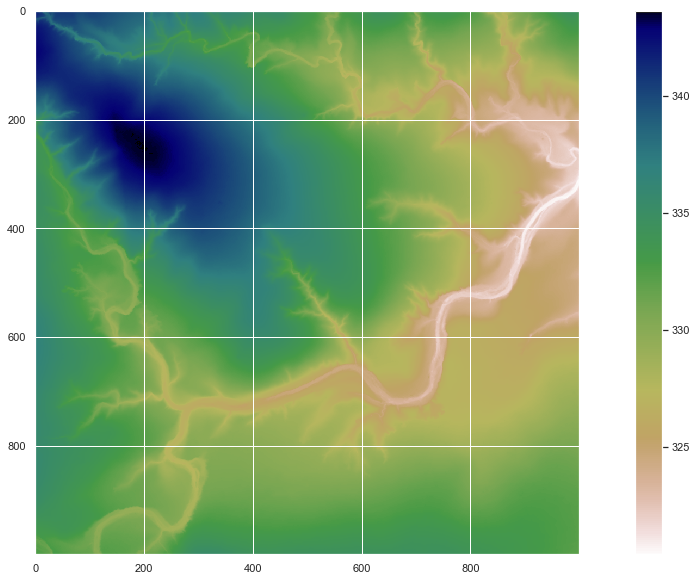

In [220]:
plt.figure(figsize=(20,10));
plt.imshow(input_DEM, cmap="gist_earth_r");
plt.colorbar();

In [159]:
print('done')

done


In [223]:
number_of_grids = 3
size_of_sample_grid = 1000
distance_from_edges = 1000
for sample_grid in range(1, number_of_grids):
    input_DEM, import_drainage_subset = findSampleArea(x, import_drainage_area, distance_from_edges, size_of_sample_grid, 0.1)
    flow_acc_surf = np.copy(input_DEM).astype('float64');
    #################################################################################################
    rows = flow_acc_surf.shape[0];
    cols = flow_acc_surf.shape[1];
    mg = RasterModelGrid((rows,cols), 1);
    z1 = mg.add_field('topographic__elevation', flow_acc_surf, at = 'node');

    sfb = SinkFillerBarnes(mg, method = 'Steepest', ignore_overfill = True);
    sfb.run_one_step();
    fa = FlowAccumulator(mg,
                        surface = 'topographic__elevation',
                        flow_director = 'FlowDirectorD8');
    fa.run_one_step();
    fd = FlowDirectorD8(mg, 'topographic__elevation');
    fd.run_one_step();

    da = np.array(mg.at_node['drainage_area'].round(4))
    frn = mg.at_node['flow__receiver_node']
    drainage_area = np.flip(da.reshape(mg.shape), 0);
    ns = np.flip(mg.status_at_node.reshape(mg.shape), 0)
    flow_rec_surf_rows = cols * rows;
    catchment_area = da.reshape(mg.shape) / (10000 * (1/working_resolution**2))

    drainage_skeleton = np.copy(catchment_area)
    drainage_skeleton[drainage_skeleton > 1] = 1
    drainage_skeleton[drainage_skeleton < 1] = 0

    sigma = 1
    truncate = 3

    copy_dem = np.copy(input_DEM)
    smoothed_dem = gaussian_filter(copy_dem, sigma=sigma, truncate = truncate)

    shape = 5
    central_value = find_median_value(circleWindow(shape))
    num_values = number_of_values(circleWindow(shape))

    DFME = generic_filter(smoothed_dem, differenceFromMeanElevation, 
                            footprint= circleWindow(shape), mode='nearest');
    DFME[DFME<-10]=-10
    DFME[DFME>=10]=10

    dfme_copy = np.copy(DFME)
    dfme_copy[dfme_copy > dfme_threshold] = 0
    dfme_copy[dfme_copy < dfme_threshold] = 1

    gully_internal_drainage = dfme_copy * catchment_area

    min_drainage = np.copy(catchment_area)
    min_drainage[min_drainage < threshold_minimum_drainage] = 0
    min_drainage[min_drainage >= threshold_minimum_drainage] = 1
    filtered_gully_drainage = gully_internal_drainage * min_drainage

    shape = 3
    central_value = find_median_value(rectangleWindow(shape, shape))
    num_values = number_of_values(rectangleWindow(shape, shape))

    filtered_gully_head_points = generic_filter(filtered_gully_drainage, 
                                ghFilter, footprint= rectangleWindow(shape,shape), mode='constant');

    gully_lengths = np.copy(filtered_gully_drainage)
    gully_lengths[gully_lengths > 0] = 1

    for i in range(1, minimum_gully_length + 1):
        if i == 1:
            input_features = gully_lengths
        else:
            input_features = remove_small_features
        window_size = i*2+1
        central_value = find_median_value(rectangleWindow(window_size, window_size))
        remove_small_features = generic_filter(input_features, 
                                                removeSmallFeatures, 
                                               footprint= rectangleWindow(window_size,window_size), 
                                               mode='constant');

    gully_heads_no_small_features = remove_small_features * filtered_gully_head_points

    initial_gh_drainage_areas = gully_heads_no_small_features * catchment_area * 10000

    augmented_catchment_area = catchment_area + initial_gh_drainage_areas - (gully_heads_no_small_features * catchment_area)

    all_initial_gully_heads = np.copy(augmented_catchment_area)
    window_size = 11
    central_value = find_median_value(rectangleWindow(window_size, window_size))
    num_values = number_of_values(rectangleWindow(window_size, window_size))

    remove_small_channel_features = generic_filter(all_initial_gully_heads, 
                                            removeSmallChannelFeatures, 
                                           footprint= rectangleWindow(window_size,window_size), 
                                           mode='constant');

    tangential_curvature_smoothed= generic_filter(smoothed_dem, hengl2003TangentialCurvature, 
                    footprint= rectangleWindow(3,3), 
                    mode='constant', extra_arguments = (working_resolution,));

    mask_tc = np.copy(tangential_curvature_smoothed)

    mask_tc[mask_tc>tangential_curvature_threshold] = 0
    mask_tc[mask_tc<=tangential_curvature_threshold] = 1
    mask_tc_NaNs = np.isnan(mask_tc)
    mask_tc[mask_tc_NaNs] = 0

    gully_heads_masked_by_curvature = gully_heads_no_small_features * mask_tc 
    
    masked_gully_heads = gully_heads_masked_by_curvature

    grid_nodes = np.array(mg.nodes.reshape(mg.shape));
    grid_nodes_float = grid_nodes.astype('float64');
    find_nodes = np.multiply(masked_gully_heads, grid_nodes);

    gh_array = np.unique(find_nodes).astype('int32');

    gh_list = gh_array.tolist();
    gh_list.remove(0);

    flow_acc_surf = np.copy(smoothed_dem).astype('float64');
    #flow_acc_surf = np.copy(input_DEM).astype('float64');
    #################################################################################################
    rows = flow_acc_surf.shape[0];
    cols = flow_acc_surf.shape[1];
    mg = RasterModelGrid((rows,cols), 1);
    z1 = mg.add_field('topographic__elevation', flow_acc_surf, at = 'node');

    sfb = SinkFillerBarnes(mg, method = 'Steepest', ignore_overfill = True);
    sfb.run_one_step();
    fa = FlowAccumulator(mg,
                        surface = 'topographic__elevation',
                        flow_director = 'FlowDirectorMFD',
                        diagonals = True);
    fa.run_one_step();
    fd = FlowDirectorMFD(mg, 'topographic__elevation', diagonals = True);
    fd.run_one_step();

    da = np.array(mg.at_node['drainage_area'].round(4))
    catchment_area_ha = np.divide(da.reshape(mg.shape), (100/working_resolution)**2)
    frn = mg.at_node['flow__receiver_node']
    drainage_area = np.flip(da.reshape(mg.shape), 0);
    frp = np.array(mg.at_node['flow__receiver_proportions']);
    ns = np.flip(mg.status_at_node.reshape(mg.shape), 0)
    flow_rec_surf_rows = cols * rows;
    flow_rec_surf = frp.reshape(flow_rec_surf_rows,8);

    catchment_area = da.reshape(mg.shape) / (10000 * (1/working_resolution**2))

    catchment_area_dict, catchment_area_node_list = findGullyHeadNode(gh_list, grid_nodes, input_DEM, catchment_area,
                                                                      input_DEM_resolution, 10, convergence_threshold, threshold_minimum_drainage)     

    gully_heads_to_keep = get_keys(catchment_area_node_list, catchment_area_dict)
    initial_gully_heads = np.isin(grid_nodes,gully_heads_to_keep).astype('int64')
    initial_gully_head_and_cp_df = pd.DataFrame.from_dict(catchment_area_dict, orient='index')
    initial_head_column = np.array(initial_gully_head_and_cp_df.index)
    initial_gully_head_and_cp_df['initial'] = initial_head_column
    initial_gully_head_and_cp_df.rename(columns={0: 'cp'}, inplace=True)

    initial_cp_nodes = np.isin(grid_nodes,catchment_area_node_list).astype('int64')

    initial_gh_nodes = np.isin(grid_nodes,initial_gully_head_and_cp_df['initial'].values).astype('int64')

    cp_da_dict = {}
    
    #new catchment area goes gere

    for input_node in catchment_area_node_list:
        result = np.where(grid_nodes == input_node);
        #################################################################################################
        # Find the index position (in the whole DEM) that corresponds to the current gully head point in the list.
        row_index = result[0][0];
        col_index = result[1][0];
        cp_da = import_drainage_subset[row_index,col_index];
        cp_da_dict[input_node] = np.round(cp_da, 5);

    cp_da_df = pd.DataFrame.from_dict(cp_da_dict, orient='index')
    cp_da_df['cp'] = cp_da_df.index
    initial_head_cp_df = initial_gully_head_and_cp_df.merge(cp_da_df, on="cp", how = 'inner')
    initial_head_cp_df.rename(columns={0: 'area'}, inplace=True)

    initial_gh_da = initial_head_cp_df['initial'].values.tolist()

    igh_da_dict = {}

    for k in initial_gh_da:
        result = np.where(grid_nodes == k);
        #################################################################################################
        # Find the index position (in the whole DEM) that corresponds to the current gully head point in the list.
        row_index = result[0][0];
        col_index = result[1][0];
        igh_da = catchment_area[row_index,col_index];
        igh_da_dict[k] = np.round(igh_da, 5);

    igh_da_df = pd.DataFrame.from_dict(igh_da_dict, orient='index')
    igh_da_df['initial'] = igh_da_df.index
    initial_head_cp_ighda_df = initial_head_cp_df.merge(igh_da_df, on="initial", how = 'inner')
    initial_head_cp_ighda_df.rename(columns={0: 'gh_area'}, inplace=True)

    downstream_5m_dict, downstream_5m_node_list = findPoint5mDownstream(gully_heads_to_keep, grid_nodes, input_DEM, catchment_area,
                                                                      input_DEM_resolution, 6) 

    downstream_5m_df = pd.DataFrame.from_dict(downstream_5m_dict, orient='index')
    downstream_5m_df['initial'] = downstream_5m_df.index
    downstream_5m_df.rename(columns={0: '5m'}, inplace=True)

    initial_head_cp_5m_df = initial_head_cp_ighda_df.merge(downstream_5m_df, on="initial", how = 'inner')

    downstream_5m_node_array = np.isin(grid_nodes,downstream_5m_node_list).astype('int64')

    size_of_edge = 30

    grid_nodes = np.array(mg.nodes.reshape(mg.shape))
    find_nodes = np.multiply(downstream_5m_node_array, grid_nodes);

    gully_head_edge_mask = np.zeros([grid_nodes.shape[0], grid_nodes.shape[1]])
    gully_head_mask_centre = np.ones([grid_nodes.shape[0] - size_of_edge*2, grid_nodes.shape[1] - size_of_edge*2])
    gully_head_edge_mask[size_of_edge:-1*(size_of_edge), size_of_edge:-1*(size_of_edge)] = gully_head_mask_centre

    remaining_gully_heads = find_nodes * gully_head_edge_mask
    gh_array = np.unique(remaining_gully_heads).astype(int);
    gh_list = gh_array.tolist();
    gh_list.remove(0);

    slope = generic_filter(input_DEM, slopeWindowMperM,
                      footprint= rectangleWindow(3,3),
                      mode='constant', extra_arguments = (input_DEM_resolution,input_DEM_resolution,));

    final_gh_and_5m_downstream, gullies_to_keep_dict = upstreamDrainageLine(20, input_DEM_resolution, grid_nodes, 
                                           input_DEM, catchment_area, DFME,gh_list, step_s, comp_d, dfme_threshold, 
                                                                            gh_min_elev)

    final_and_5m_df = pd.DataFrame.from_dict(final_gh_and_5m_downstream, orient='index')
    final_and_5m_df['5m'] = final_and_5m_df.index
    initial_cp_5m_final_df = initial_head_cp_5m_df.merge(final_and_5m_df, on="5m", how = 'inner')
    initial_cp_5m_final_df.rename(columns={0: 'final'}, inplace=True)

    final_5m_downstream, final_gully_heads = get_values(final_gh_and_5m_downstream)

    slope_above_head, elevation_above_head = upstreamSlope(20, input_DEM_resolution, grid_nodes, 
                                           input_DEM, catchment_area, DFME,final_gully_heads, step_s, comp_d, 5);

    slope_above_head_df = pd.DataFrame.from_dict(slope_above_head, orient='index');
    slope_above_head_df.rename(columns={0: 'GHSlope', 1: 'final'}, inplace=True);

    elevation_above_head_df = pd.DataFrame.from_dict(elevation_above_head, orient='index');
    elevation_above_head_df.rename(columns={0: 'GHelevation', 1: 'final'}, inplace=True);

    slope_and_elevation_5m_df = slope_above_head_df.merge(elevation_above_head_df, on="final", how = 'inner')

    slope_above_head_10m, elevation_above_head_10m = upstreamSlope(20, input_DEM_resolution, grid_nodes, 
                                           input_DEM, catchment_area, DFME,final_gully_heads, step_s, comp_d, 10);

    slope_above_head_10m_df = pd.DataFrame.from_dict(slope_above_head_10m, orient='index');
    slope_above_head_10m_df.rename(columns={0: 'GHSlope10', 1: 'final'}, inplace=True);

    elevation_above_head_10m_df = pd.DataFrame.from_dict(elevation_above_head_10m, orient='index');
    elevation_above_head_10m_df.rename(columns={0: 'GHelevation10', 1: 'final'}, inplace=True);

    slope_and_elevation_10m_df1 = slope_and_elevation_5m_df.merge(slope_above_head_10m_df, on="final", how = 'inner')

    slope_and_elevation_10m_df = slope_and_elevation_10m_df1.merge(elevation_above_head_10m_df, on="final", how = 'inner')

    slope_and_elevation_10m_df['drainage_slope'] = slope_and_elevation_10m_df.apply(lambda x: drainageSlope(x['GHelevation'], x['GHelevation10']), axis=1)

    final_gully_head_nodes = np.isin(grid_nodes,final_gully_heads).astype('int64')


    list_of_final_gully_heads = []
    gully_edges_dict = {}
    for key, value in final_gh_and_5m_downstream.items():
        cp = key
        print('cp: ',cp)
        gh = value
        print('gh: ', gh)
        gh_lat = np.where(grid_nodes == gh)[0][0]
        cp_lat = np.where(grid_nodes == cp)[0][0]
        gh_lon = np.where(grid_nodes == gh)[1][0]
        cp_lon = np.where(grid_nodes == cp)[1][0]

        lat_displacement = cp_lat - gh_lat
        print('lat: ', lat_displacement)
        lon_displacement = gh_lon - cp_lon
        print('lon: ', lon_displacement)

        # a^2 + b^2 = c^2
        gully_length = np.sqrt(lat_displacement**2 + lon_displacement**2)

        gully_angle = gullyUnknownAngle(lat_displacement, lon_displacement)   

        gully_and_cross_section = GullyOrientation(gully_angle, key, mg.shape)

        approx_angle = gully_and_cross_section.closest_angle

        cross_section_nodes = gully_and_cross_section.cross_section(line_length)

        result = np.where(grid_nodes == key)
        #################################################################################################
        # Find the index position (in the whole DEM) that corresponds to the current gully head point in the list.
        row_index = result[0][0];
        col_index = result[1][0];
        #################################################################################################
        # Create a subset based on above. Plus 1 to bottom abnd right so that the currenmmt gully ead node is always the 
        # central grid node of the subset.
        subset_row_top = int(row_index - line_length)
        subset_row_bot = int(row_index + line_length) + 1
        subset_col_left = int(col_index - line_length)
        subset_col_right = int(col_index + line_length) + 1
        #################################################################################################
        # Restrict the size of the subset in cases where it is on the edge of a DEM.
        subset_row_top_adjusted = max(subset_row_top, 0);
        subset_row_bot_adjusted = min(subset_row_bot, input_DEM.shape[0]);
        subset_col_left_adjusted = max(subset_col_left, 0);
        subset_col_right_adjusted = min(subset_col_right, input_DEM.shape[1]);
        #################################################################################################
        # Find the offset required by restricting the size of the subset around DEM edges.
        # This offset is needed to find the new location of the current gully head grid cell (no longer center of the subset).
        offset_row_top = int(np.sqrt((subset_row_top - subset_row_top_adjusted)**2)) * -1;
        offset_row_bot = int(np.sqrt((subset_row_bot - subset_row_bot_adjusted)**2));
        offset_col_left = int(np.sqrt((subset_col_left - subset_col_left_adjusted)**2)) * -1;
        offset_col_right = int(np.sqrt((subset_col_right - subset_col_right_adjusted)**2));
        #################################################################################################
        # Create subset around the current gully head grid node. 
        grid_nodes_subset_copy = np.copy(grid_nodes).astype('int32');
        grid_nodes_subset = grid_nodes_subset_copy[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                     subset_col_left_adjusted:subset_col_right_adjusted]

        lat = grid_nodes_subset.shape[0]
        lon = grid_nodes_subset.shape[1]

        nodes_1d = np.squeeze(grid_nodes_subset.reshape(1, lat * lon))

        cross_section_subset_mask = np.isin(nodes_1d,cross_section_nodes).reshape(grid_nodes_subset.shape)
        cross_section_subset_image = cross_section_subset_mask.astype('int64')

        #################################################################################################
        # Take subsets of desired surface parameters for gulyl analysis (e.g. DFME, slope, curvature etc)
        #################################################################################################
        elevation_subset_copy = np.copy(input_DEM).astype('float32');
        cross_section_elevation = elevation_subset_copy[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                     subset_col_left_adjusted:subset_col_right_adjusted]

        cross_section_elevation[~cross_section_subset_mask] = np.nan
        cross_section_elevation_1d = np.squeeze(cross_section_elevation.reshape(1, lat * lon))
        #################################################################################################
        dfme_subset_copy = np.copy(DFME).astype('float32');
        cross_section_dfme = dfme_subset_copy[subset_row_top_adjusted:subset_row_bot_adjusted, 
                                     subset_col_left_adjusted:subset_col_right_adjusted]

        cross_section_dfme[~cross_section_subset_mask] = np.nan
        cross_section_dfme_1d = np.squeeze(cross_section_dfme.reshape(1, lat * lon))
        #################################################################################################

        node_cross_section_dfme_dict = {}
        for A, B in zip(nodes_1d, cross_section_dfme_1d):
            node_cross_section_dfme_dict[A] = B

        node_cross_section_elevation_dict = {}
        for A, B in zip(nodes_1d, cross_section_elevation_1d):
            node_cross_section_elevation_dict[A] = B

        dfme_cross_section_unordered = { key:value for key, 
                                         value in node_cross_section_dfme_dict.items() if ~np.isnan(value) }

        elevation_cross_section_unordered = { key:value for key, 
                                             value in node_cross_section_elevation_dict.items() if ~np.isnan(value) }

        ds = [dfme_cross_section_unordered, elevation_cross_section_unordered]
        d = {}
        for k in dfme_cross_section_unordered.keys():
            d[k] = tuple(d[k] for d in ds)

        cross_section_parameters = pd.DataFrame.from_dict(d)

        cross_section_parameters.rename(index={0:'DFME', 1:'Elevation'}, inplace=True)

        cross_section_parameters_transpose = cross_section_parameters.T

        cross_section_parameters_transpose.insert(0, "Distance", 0)

        for j in range(0, (line_length * 2)+1):
            if j < line_length:
                cross_section_parameters_transpose.iloc[j,0] = -line_length + j
            else:
                cross_section_parameters_transpose.iloc[j,0] = j - line_length

        cross_section_parameters_transpose['Node'] = cross_section_parameters_transpose.index.values

        dir1, dir1_nodes, dir2, dir2_nodes = assignDirection(cross_section_parameters_transpose, 
                                                     gully_and_cross_section.closest_angle)

        dir1e, dir1_nodes, dir2e, dir2_nodes = assignDirectionElev(cross_section_parameters_transpose, 
                                                 gully_and_cross_section.closest_angle)



        #outcome_d1, D1 = checkGullyEdges(dir1,step_s,comp_d,-0.2,-0.2)
        #outcome_d2, D2 = checkGullyEdges(dir2,step_s,comp_d,-0.2,-0.2)

        outcome_d1, D1 = checkGullyEdgesElev(dir1,dir1e, step_s,comp_d,dfme_threshold,gh_min_elev, gh_relief);
        outcome_d2, D2 = checkGullyEdgesElev(dir2, dir2e, step_s,comp_d,dfme_threshold,gh_min_elev, gh_relief);

        if outcome_d1 == 'yes' and outcome_d2 == 'yes':
            list_of_final_gully_heads.append(key)
            # Directions will depend on orientation so need two sets of schemes.
            if approx_angle == 180 or approx_angle == 225 or approx_angle == 270 or approx_angle == 315:

                points_next_to_head_d1 = pointsAlongGully(dir1_nodes[D1], approx_angle, 5, grid_nodes)
                points_next_to_head_d2 = pointsAlongGully(dir2_nodes[D2], approx_angle, 5, grid_nodes)

                print('d1 : ', dir1_nodes[D1], 'd2: ', dir2_nodes[D2], 'New points: ', 
                      points_next_to_head_d1, points_next_to_head_d2, 'angle: ', approx_angle)

                gully_edges_dict[key] = [dir1_nodes[D1], dir2_nodes[D2], points_next_to_head_d1, points_next_to_head_d2]

            else:
                points_next_to_head_d1 = pointsAlongGully(dir1_nodes[D1], approx_angle, 5, grid_nodes)
                points_next_to_head_d2 = pointsAlongGully(dir2_nodes[D2], approx_angle, 5, grid_nodes)

                print('d1 : ', dir1_nodes[D1], 'd2: ', dir2_nodes[D2], 'New points: ', 
                      points_next_to_head_d1, points_next_to_head_d2, 'angle: ', approx_angle)

                gully_edges_dict[key] = [dir2_nodes[D2],dir1_nodes[D1], points_next_to_head_d2, points_next_to_head_d1]

        else:
            print('no')

    final_5m_downstream_nodes = np.isin(grid_nodes,list_of_final_gully_heads).astype('int64')

    gully_edges_df = pd.DataFrame.from_dict(gully_edges_dict).T
    gully_edges_df.columns = ['LeftCP', 'RightCP', 'LeftGH', 'RightGH']
    gully_edges_df['5m'] = gully_edges_df.index
    initial_cp_5m_final_edges_df = initial_cp_5m_final_df.merge(gully_edges_df, on="5m", how = 'inner')

    final_gh_da = initial_cp_5m_final_edges_df['final'].values.tolist() 

    fgh_da_dict = {}

    for i in final_gh_da:
        result = np.where(grid_nodes == i);
        #################################################################################################
        # Find the index position (in the whole DEM) that corresponds to the current gully head point in the list.
        row_index = result[0][0];
        col_index = result[1][0];
        fgh_da = catchment_area[row_index,col_index];
        fgh_da_dict[i] = np.round(fgh_da, 5);

    fgh_da_df = pd.DataFrame.from_dict(fgh_da_dict, orient='index')
    fgh_da_df['final'] = fgh_da_df.index
    initial_cp_5m_final_da_df = initial_cp_5m_final_edges_df.merge(fgh_da_df, on="final", how = 'inner')
    initial_cp_5m_final_da_df.rename(columns={0: 'fgh_area'}, inplace=True)

    final_gh_copy = initial_cp_5m_final_da_df.copy()

    final_gh_copy['final_drainage_ratio'] = final_gh_copy.apply(lambda x: drainageDifference(x['area'], x['fgh_area']), axis=1)

    final_gh_copy.drop(final_gh_copy[final_gh_copy['final_drainage_ratio'] > drainage_ratio_threshold].index, inplace = True) 

    gully_topographic_data = final_gh_copy.merge(slope_and_elevation_10m_df, on="final", how = 'inner')

    gully_topographic_data['GHSlopeMean'] = gully_topographic_data[['GHSlope', 'GHSlope10']].mean(axis=1)

    left_edge_points = gully_edges_df['LeftCP'].values
    right_edge_points = gully_edges_df['RightCP'].values
    left_head_points = gully_edges_df['LeftGH'].values
    right_head_points = gully_edges_df['RightGH'].values
    gully_left_edges = np.isin(grid_nodes,left_edge_points).astype('int64')
    gully_right_edges = np.isin(grid_nodes,right_edge_points).astype('int64')
    gully_left_head = np.isin(grid_nodes,left_head_points).astype('int64')
    gully_right_head = np.isin(grid_nodes,right_head_points).astype('int64')

    left_cp_slope = getSlopeValues(left_edge_points, slope, grid_nodes)
    right_cp_slope = getSlopeValues(right_edge_points, slope, grid_nodes)
    left_head_slope = getSlopeValues(left_head_points, slope, grid_nodes)
    right_head_slope = getSlopeValues(right_head_points, slope, grid_nodes)

    left_cp_slope_df = pd.DataFrame.from_dict(left_cp_slope, orient='index')
    left_cp_slope_df['LeftCP'] = left_cp_slope_df.index
    all_data_plus_left_cp = gully_topographic_data.merge(left_cp_slope_df, on="LeftCP", how = 'inner')
    all_data_plus_left_cp.rename(columns={0: 'LeftCPslope'}, inplace=True)

    right_cp_slope_df = pd.DataFrame.from_dict(right_cp_slope, orient='index')
    right_cp_slope_df['RightCP'] = right_cp_slope_df.index
    all_data_plus_right_cp = all_data_plus_left_cp.merge(right_cp_slope_df, on="RightCP", how = 'inner')
    all_data_plus_right_cp.rename(columns={0: 'RightCPslope'}, inplace=True)

    left_head_slope_df = pd.DataFrame.from_dict(left_head_slope, orient='index')
    left_head_slope_df['LeftGH'] = left_head_slope_df.index
    all_data_plus_left_gh = all_data_plus_right_cp.merge(left_head_slope_df, on="LeftGH", how = 'inner')
    all_data_plus_left_gh.rename(columns={0: 'LeftGHslope'}, inplace=True)

    right_head_slope_df = pd.DataFrame.from_dict(right_head_slope, orient='index')
    right_head_slope_df['RightGH'] = right_head_slope_df.index
    all_data_plus_right_gh = all_data_plus_left_gh.merge(right_head_slope_df, on="RightGH", how = 'inner')
    all_data_plus_right_gh.rename(columns={0: 'RightGHslope'}, inplace=True)

    all_data_plus_right_gh['median'] = all_data_plus_right_gh[['LeftCPslope', 'RightCPslope','LeftGHslope','RightGHslope','GHSlope']].median(axis=1)
    all_data_plus_right_gh['std'] = all_data_plus_right_gh[['LeftCPslope', 'RightCPslope','LeftGHslope','RightGHslope','GHSlope']].std(axis=1)

    gully_head_node_array = np.isin(grid_nodes,all_data_plus_right_gh['final'].values).astype('int64')

    df_filtered = all_data_plus_right_gh[all_data_plus_right_gh['std'] < 0.05] 
    df_filtered_new = df_filtered.reset_index()

    slope_to_use = 'drainage_slope' # Type of slope calculation for plots ('drainage_slope' or 'median')

    data_to_plot = all_data_plus_right_gh #Dataset used for plots. 'median' slope_to_use needs 'df_filtered_new'
                                            #otherwise 'all_data_plus_right_gh'

    data_to_plot['log_area'] = np.log10(data_to_plot['area'])
    data_to_plot['log_slope'] = np.log10(data_to_plot[slope_to_use])

    os.chdir(out_location)
    data_to_plot.to_csv(input_data[:-4] + str(sample_grid) + '.csv')


max ca:  0.68334624
Node id:  220 Catchment area:  0.41351372
Node id:  199 Catchment area:  0.49652699
max ca:  0.4427314
Node id:  220 Catchment area:  0.25539171
Node id:  199 Catchment area:  0.32004179
Node id:  178 Catchment area:  0.2561369
max ca:  0.05775323
Node id:  220 Catchment area:  0.03303117
Node id:  200 Catchment area:  0.0407351
Node id:  180 Catchment area:  0.03874899
Node id:  159 Catchment area:  0.04652221
Node id:  139 Catchment area:  0.04811728
Node id:  119 Catchment area:  0.03617388
Node id:  98 Catchment area:  0.05494496
Node id:  77 Catchment area:  0.05196626
Node id:  56 Catchment area:  0.03635391
Node id:  36 Catchment area:  0.05775323
max ca:  1.17810235
Node id:  220 Catchment area:  0.91380963
Node id:  200 Catchment area:  0.8974726
max ca:  6.38622779
Node id:  220 Catchment area:  0.70924374
Node id:  200 Catchment area:  5.54715033
max ca:  4.953553
Node id:  220 Catchment area:  3.82810639
Node id:  221 Catchment area:  1.91017049
Node id:

max ca:  51.92239878
Node id:  220 Catchment area:  2.84094583
Node id:  200 Catchment area:  50.89448663
Node id:  222 Catchment area:  39.19137958
max ca:  0.44609829
Node id:  220 Catchment area:  0.14743533
Node id:  241 Catchment area:  0.22006524
max ca:  0.46431874
Node id:  220 Catchment area:  0.0160789
Node id:  221 Catchment area:  0.06873664
Node id:  222 Catchment area:  0.32563046
max ca:  0.26453221
Node id:  220 Catchment area:  0.12170314
max ca:  1.11147821
Node id:  220 Catchment area:  0.04448283
Node id:  221 Catchment area:  0.08450606
Node id:  243 Catchment area:  0.11077752
max ca:  0.48502032
Node id:  220 Catchment area:  0.2077481
max ca:  0.83694671
Node id:  220 Catchment area:  0.2920837
Node id:  242 Catchment area:  0.44085372
max ca:  0.93310067
Node id:  220 Catchment area:  0.03090351
Node id:  240 Catchment area:  0.08769908
Node id:  261 Catchment area:  0.17097863
Node id:  282 Catchment area:  0.67877527
Node id:  303 Catchment area:  0.57237582


Node id:  220 Catchment area:  0.0361734
Node id:  219 Catchment area:  0.04409898
Node id:  218 Catchment area:  0.04754182
Node id:  217 Catchment area:  0.04507227
Node id:  216 Catchment area:  0.03699617
Node id:  236 Catchment area:  0.05726563
Node id:  235 Catchment area:  0.04727387
Node id:  255 Catchment area:  0.0518024
Node id:  276 Catchment area:  0.02134131
Node id:  275 Catchment area:  0.04464478
max ca:  0.13682406
Node id:  220 Catchment area:  0.02684011
Node id:  199 Catchment area:  0.07927458
max ca:  0.08868596
Node id:  220 Catchment area:  0.06118547
max ca:  0.10015799
Node id:  220 Catchment area:  0.04566228
Node id:  221 Catchment area:  0.05279646
max ca:  0.62629446
Node id:  84 Catchment area:  0.41351372
Node id:  71 Catchment area:  0.49652699
Node id:  58 Catchment area:  0.58582337
Node id:  45 Catchment area:  0.62629446
Node id:  32 Catchment area:  0.4337227
Node id:  18 Catchment area:  0.59409837
5
max ca:  0.40656321
Node id:  84 Catchment ar

Node id:  84 Catchment area:  0.1491542
Node id:  70 Catchment area:  0.20354653
Node id:  56 Catchment area:  0.25550419
Node id:  43 Catchment area:  0.29425633
Node id:  30 Catchment area:  0.14923067
Node id:  16 Catchment area:  0.24714358
5
max ca:  0.14372812
Node id:  84 Catchment area:  0.02009278
Node id:  71 Catchment area:  0.06331891
Node id:  58 Catchment area:  0.11616374
Node id:  45 Catchment area:  0.0588784
Node id:  33 Catchment area:  0.14372812
Node id:  20 Catchment area:  0.08557283
5
max ca:  0.23411216
Node id:  84 Catchment area:  0.06786639
Node id:  85 Catchment area:  0.11691318
Node id:  99 Catchment area:  0.17149362
Node id:  113 Catchment area:  0.18820752
Node id:  126 Catchment area:  0.14844197
Node id:  140 Catchment area:  0.19879721
5
max ca:  0.44078189
Node id:  84 Catchment area:  0.02361623
Node id:  85 Catchment area:  0.05466429
Node id:  86 Catchment area:  0.39733285
Node id:  99 Catchment area:  0.43362133
Node id:  113 Catchment area:  

Node id:  84 Catchment area:  0.10804848
Node id:  83 Catchment area:  0.15264048
Node id:  82 Catchment area:  0.21982285
Node id:  81 Catchment area:  0.26459525
Node id:  80 Catchment area:  0.20936212
Node id:  66 Catchment area:  0.30634245
5
max ca:  2.39684837
Node id:  84 Catchment area:  0.0698591
Node id:  98 Catchment area:  0.11827171
Node id:  112 Catchment area:  2.30979774
Node id:  113 Catchment area:  2.37660339
Node id:  114 Catchment area:  0.99013654
Node id:  102 Catchment area:  2.39284146
5
max ca:  0.62381242
Node id:  84 Catchment area:  0.47979362
Node id:  85 Catchment area:  0.45037594
Node id:  86 Catchment area:  0.46714141
Node id:  87 Catchment area:  0.53494009
Node id:  75 Catchment area:  0.22507866
Node id:  76 Catchment area:  0.30662147
5
max ca:  1.25694343
Node id:  84 Catchment area:  0.11626915
Node id:  98 Catchment area:  0.20906727
Node id:  112 Catchment area:  0.29398647
Node id:  125 Catchment area:  0.43063242
Node id:  126 Catchment are

Node id:  84 Catchment area:  0.06118547
Node id:  70 Catchment area:  0.06504879
Node id:  69 Catchment area:  0.06721879
Node id:  68 Catchment area:  0.02922448
Node id:  54 Catchment area:  0.06676306
Node id:  53 Catchment area:  0.03472064
5
max ca:  0.08436393
Node id:  84 Catchment area:  0.04566228
Node id:  85 Catchment area:  0.05279646
Node id:  86 Catchment area:  0.05213896
Node id:  87 Catchment area:  0.05486692
Node id:  88 Catchment area:  0.05054239
Node id:  76 Catchment area:  0.07409086
5
840
(41, 41)
839
880
879
878
918
958
999
1039
998
[325.55499, 325.608, 325.65601, 325.72601, 325.84399, 325.94, 325.98099, 326.03, 326.05899]
node:  30530
minimum downstream value:  -0.236588
mean upstream value:  -0.0651189
std upstream value:  0.0489949
840
(41, 41)
881
921
961
1001
1041
1081
1122
1162
1202
1243
1283
1323
1363
1404
1444
1485
1525
1565
1564
1604
[327.88199, 327.90601, 327.90601, 327.95599, 328.12701, 328.22299, 328.30899, 328.30801, 328.33301, 328.45599, 328.548

840
(41, 41)
880
920
960
1000
999
1039
1038
1078
1077
1076
1075
1115
1155
1195
1235
1275
1315
1356
1398
1440
[328.84399, 328.957, 329.00101, 329.048, 329.12299, 329.151, 329.198, 329.22601, 329.29001, 329.35599, 329.40701, 329.457, 329.509, 329.55099, 329.60101, 329.62201, 329.625, 329.68201, 329.84399, 330.03201]
node:  116131
minimum downstream value:  -0.286656
mean upstream value:  -0.221331
std upstream value:  0.0127614
minimum downstream value:  -0.278626
mean upstream value:  -0.224117
std upstream value:  0.011802
minimum downstream value:  -0.214316
mean upstream value:  -0.208354
std upstream value:  0.0126293
minimum downstream value:  -0.214316
mean upstream value:  -0.192314
std upstream value:  0.0246408
minimum downstream value:  -0.210438
mean upstream value:  -0.168673
std upstream value:  0.0170152
minimum downstream value:  -0.210438
mean upstream value:  -0.161165
std upstream value:  0.00726168
minimum downstream value:  -0.19195
mean upstream value:  -0.165558
st

840
(41, 41)
881
922
963
1004
1045
1086
1127
1168
1209
1250
1292
1334
1376
1418
1460
1502
1543
1584
1625
[334.39999, 334.427, 334.556, 334.73001, 334.94501, 335.14899, 335.26801, 335.32999, 335.38699, 335.435, 335.52701, 335.61401, 335.673, 335.72198, 335.78, 335.82901, 335.89499, 335.96399, 336.05499]
node:  298199
minimum downstream value:  -0.178648
mean upstream value:  -0.0117672
std upstream value:  0.0166414
minimum downstream value:  -0.127414
mean upstream value:  0.0
std upstream value:  0.0
minimum downstream value:  -0.0353017
mean upstream value:  0.0
std upstream value:  0.0
minimum downstream value:  0.0
mean upstream value:  0.0
std upstream value:  0.0
minimum downstream value:  0.0
mean upstream value:  0.0
std upstream value:  0.0
minimum downstream value:  0.0
mean upstream value:  0.0
std upstream value:  0.0
minimum downstream value:  0.0
mean upstream value:  -0.00112086
std upstream value:  0.00158514
minimum downstream value:  0.0
mean upstream value:  -0.00705

840
(41, 41)
798
797
755
754
753
711
669
628
627
585
543
542
500
458
417
376
336
296
255
214
[326.93201, 327.02499, 326.93701, 326.888, 326.92001, 327.07599, 327.026, 327.01599, 326.94299, 327.577, 327.73499, 327.72601, 327.85501, 328.065, 328.39801, 328.681, 329.42099, 329.64301, 329.686, 329.72299]
node:  545668
minimum downstream value:  -0.542065
mean upstream value:  -0.71569
std upstream value:  0.0435063
minimum downstream value:  -0.565253
mean upstream value:  -0.739739
std upstream value:  0.0364096
minimum downstream value:  -0.651079
mean upstream value:  -0.774119
std upstream value:  0.0170355
minimum downstream value:  -0.67985
mean upstream value:  -0.711394
std upstream value:  0.0883619
minimum downstream value:  -0.67985
mean upstream value:  -0.632466
std upstream value:  0.117719
minimum downstream value:  -0.6903
mean upstream value:  -0.515904
std upstream value:  0.0591926
minimum downstream value:  -0.751996
mean upstream value:  -0.490669
std upstream value:  

840
(41, 41)
798
756
715
674
633
591
590
549
507
466
424
382
381
340
298
256
215
173
172
131
[326.84799, 326.77802, 326.853, 327.08499, 327.22601, 327.186, 327.48901, 327.96201, 328.37201, 328.41501, 328.44101, 328.48199, 328.51099, 328.54199, 328.659, 328.716, 328.772, 328.798, 328.836, 328.909]
node:  594654
minimum downstream value:  -0.54276
mean upstream value:  -0.364891
std upstream value:  0.0929434
minimum downstream value:  -0.503587
mean upstream value:  -0.267033
std upstream value:  0.11295
minimum downstream value:  -0.441702
mean upstream value:  -0.127414
std upstream value:  0.096692
840
(41, 41)
839
838
837
877
876
916
915
914
913
912
911
910
909
908
948
988
1029
1069
1109
1150
[325.71301, 325.745, 325.82599, 325.909, 325.996, 326.18701, 326.42099, 326.60999, 326.638, 326.65601, 326.66699, 326.68201, 326.69601, 326.711, 326.742, 326.77701, 326.78799, 326.80899, 326.82901, 326.84299]
node:  620799
minimum downstream value:  -0.315512
mean upstream value:  -0.134261
std

840
(41, 41)
839
838
796
795
753
752
751
709
708
707
665
664
663
662
661
660
659
658
657
616
[331.25, 331.33701, 331.448, 331.98001, 332.48099, 333.479, 334.12799, 334.147, 334.19699, 334.228, 334.25201, 334.26599, 334.28699, 334.30701, 334.336, 334.36499, 334.39401, 334.427, 334.465, 334.491]
node:  669349
minimum downstream value:  -0.683026
mean upstream value:  -0.13425
std upstream value:  0.189859
minimum downstream value:  -0.653337
mean upstream value:  0.0
std upstream value:  0.0
840
(41, 41)
880
879
878
877
917
916
956
955
995
994
993
992
991
990
1030
1070
1069
1068
1067
1108
[327.07401, 327.12799, 327.14401, 327.198, 327.246, 327.354, 327.38599, 327.43301, 327.47198, 327.5, 327.58401, 327.634, 327.69601, 327.909, 328.401, 328.94501, 328.96799, 329.022, 329.065, 329.077]
node:  670532
minimum downstream value:  -0.405441
mean upstream value:  -0.360443
std upstream value:  0.02321
minimum downstream value:  -0.359122
mean upstream value:  -0.373039
std upstream value:  0.031

840
(41, 41)
800
759
718
678
637
597
598
558
518
477
436
395
353
311
269
268
267
225
224
182
[330.23099, 330.22101, 330.32401, 330.44101, 330.55099, 330.77701, 330.91299, 331.72299, 332.04599, 332.07199, 332.11401, 332.14499, 332.211, 332.26001, 332.29901, 332.323, 332.354, 332.397, 332.436, 332.49799]
node:  686398
minimum downstream value:  -0.386669
mean upstream value:  -0.470105
std upstream value:  0.117175
minimum downstream value:  -0.451393
mean upstream value:  -0.267034
std upstream value:  0.19927
minimum downstream value:  -0.496982
mean upstream value:  -0.107521
std upstream value:  0.152058
minimum downstream value:  -0.478539
mean upstream value:  0.0
std upstream value:  0.0
840
(41, 41)
881
921
962
1002
1042
1041
1081
1121
1161
1201
1242
1283
1324
1365
1406
1447
1488
1529
1570
1611
[326.13501, 326.23901, 326.29501, 326.358, 326.43399, 326.539, 326.82401, 327.23999, 327.60599, 327.673, 327.703, 327.733, 327.767, 327.79099, 327.811, 327.83099, 327.854, 327.883, 327.912

840
(41, 41)
798
756
714
672
630
588
587
545
503
461
419
377
376
375
374
373
331
289
247
206
[330.45801, 330.69601, 330.827, 331.09299, 331.327, 331.51599, 331.62601, 331.83801, 331.98999, 332.11499, 332.26099, 332.39801, 332.48999, 332.57901, 332.66299, 332.75601, 332.86801, 332.95801, 333.00601, 333.02301]
node:  872294
minimum downstream value:  -0.255617
mean upstream value:  -0.172379
std upstream value:  0.0258837
840
(41, 41)
799
759
718
678
638
597
557
516
475
434
393
351
310
268
226
184
143
101
60
59
[335.495, 335.57199, 335.672, 335.65799, 335.83499, 335.91599, 335.97501, 336.01001, 336.082, 336.103, 336.09399, 336.22501, 336.29001, 336.33701, 336.45099, 336.51099, 336.53101, 336.67099, 336.77899, 336.82901]
node:  877128
minimum downstream value:  -0.254022
mean upstream value:  -0.197246
std upstream value:  0.0185566
840
(41, 41)
881
921
920
919
918
917
916
874
873
872
871
870
869
827
785
743
702
660
619
577
[329.25101, 329.276, 329.28601, 329.29401, 329.332, 329.422, 329.

840
(41, 41)
839
838
796
754
712
711
5   5
710
709
667
666
665
664
663
621
580
579
537
536
494
452
840
(41, 41)
799
758
716
674
633
592
5   5
550
508
467
426
385
344
302
260
219
177
135
93
51
50
840
(41, 41)
799
759
719
678
637
596
5   5
555
514
473
432
391
350
309
267
226
184
143
101
60
59
840
(41, 41)
800
759
718
677
635
593
5   5
551
509
467
425
384
342
300
259
217
175
134
93
52
51
840
(41, 41)
881
922
963
1004
1044
1084
5   5
1124
1164
1163
1203
1243
1283
1323
1363
1403
1402
1401
1400
1399
1439
840
(41, 41)
839
838
837
795
753
712
5   5
671
630
589
548
507
466
424
382
340
299
258
217
175
134
840
(41, 41)
839
798
756
715
673
631
5   5
630
589
547
505
464
422
421
380
338
296
255
214
172
130
840
(41, 41)
839
798
756
715
673
631
5   5
630
589
547
505
464
422
421
380
338
296
255
214
172
130
840
(41, 41)
839
879
878
877
876
875
5   5
874
873
872
871
911
951
992
1032
1072
1113
1153
1193
1233
1273
840
(41, 41)
798
756
714
672
630
588
5   5
587
586
585
584
624
623
622
621
620
619
618
617
61

840
(41, 41)
881
922
963
1004
1045
1086
1128
1169
1211
1252
1294
10   10
1335
1377
1418
1459
1500
1541
1582
1623
1624
840
(41, 41)
880
879
878
877
876
875
874
873
872
871
870
10   10
910
909
908
907
906
905
904
944
903
840
(41, 41)
800
760
719
678
637
595
553
511
510
509
467
10   10
466
424
382
340
299
257
215
174
132
840
(41, 41)
880
920
960
1000
1041
1082
1123
1164
1205
1246
1287
10   10
1328
1369
1410
1451
1492
1533
1574
1615
1614
840
(41, 41)
839
797
755
714
672
631
590
549
507
465
423
10   10
381
380
338
296
254
212
170
128
86
840
(41, 41)
880
920
960
959
999
1039
1038
1037
1036
1035
1034
10   10
1033
1032
1031
1030
1070
1110
1150
1149
1190
840
(41, 41)
882
883
925
966
1008
1050
1091
1132
1173
1214
1255
10   10
1296
1337
1378
1419
1460
1501
1542
1583
1624
840
(41, 41)
882
883
925
966
1008
1050
1091
1132
1173
1214
1255
10   10
1296
1337
1378
1419
1460
1501
1542
1583
1624
840
(41, 41)
839
797
796
795
753
712
670
628
629
588
546
10   10
504
462
420
419
377
376
375
333
291
840
(41, 41

elevation difference:  0.259002685547
elevation difference:  0.183990478516
elevation difference:  -0.398010253906
elevation difference:  -0.700012207031
elevation difference:  -1.12600708008
elevation difference:  -1.22698974609
elevation difference:  -0.889007568359
elevation difference:  -0.674987792969
elevation difference:  -0.322998046875
elevation difference:  -0.465026855469
elevation difference:  -0.550994873047
elevation difference:  -0.753997802734
elevation difference:  -0.718994140625
elevation difference:  -0.421997070313
elevation difference:  0.701995849609
no
cp:  247155
gh:  251156
lat:  -4
lon:  1
Quadrant = Q4 min angle 90 max angle 180
north-south gully
elevation difference:  0.961029052734
elevation difference:  0.752014160156
elevation difference:  0.476989746094
elevation difference:  0.476013183594
elevation difference:  0.506988525391
elevation difference:  0.589019775391
elevation difference:  0.594024658203
elevation difference:  0.477996826172
elevation dif

elevation difference:  1.6960144043
elevation difference:  1.13101196289
west_to_east gully
west_to_east gully
d1 :  555721 d2:  563721 New points:  555716 563716 angle:  270
cp:  564752
gh:  567745
lat:  -3
lon:  -7
Quadrant = Q3 min angle 180 max angle 270
northeast-southwest gully
elevation difference:  1.31298828125
elevation difference:  0.901000976563
southwest_to_notheast gully
southwest_to_notheast gully
d1 :  560748 d2:  568756 New points:  565747 573755 angle:  225
cp:  592652
gh:  588651
lat:  4
lon:  -1
Quadrant = Q2 min angle 270 max angle 360
north-south gully
elevation difference:  1.11898803711
elevation difference:  1.05200195313
north_to_south gully
north_to_south gully
d1 :  592648 d2:  592656 New points:  587648 587656 angle:  360
cp:  594654
gh:  588651
lat:  6
lon:  -3
Quadrant = Q2 min angle 270 max angle 360
northwest-southeast gully
elevation difference:  1.06298828125
elevation difference:  0.52099609375
elevation difference:  1.23599243164
northwest_to_southe

elevation difference:  1.04098510742
elevation difference:  0.862976074219
elevation difference:  0.674987792969
elevation difference:  0.513000488281
elevation difference:  0.339996337891
elevation difference:  0.202026367188
elevation difference:  0.549011230469
elevation difference:  0.640014648438
elevation difference:  0.769012451172
elevation difference:  0.709991455078
elevation difference:  0.114990234375
elevation difference:  -0.608001708984
elevation difference:  -0.984008789063
elevation difference:  -1.09201049805
elevation difference:  0.118011474609
elevation difference:  -0.890014648438
elevation difference:  -0.890014648438
elevation difference:  -0.369995117188
elevation difference:  0.169006347656
elevation difference:  0.179992675781
elevation difference:  -0.0749816894531
elevation difference:  -0.799011230469
elevation difference:  -0.807006835938
elevation difference:  -0.746978759766
elevation difference:  -0.492004394531
elevation difference:  -0.0889892578125


elevation difference:  1.16598510742
elevation difference:  -0.0140075683594
elevation difference:  0.00900268554688
elevation difference:  0.010009765625
elevation difference:  0.00802612304688
elevation difference:  0.0459899902344
elevation difference:  0.109985351563
elevation difference:  0.165985107422
elevation difference:  0.165985107422
elevation difference:  0.0820007324219
elevation difference:  -0.00399780273438
elevation difference:  -0.0610046386719
elevation difference:  0.0450134277344
elevation difference:  0.324005126953
elevation difference:  0.625
no
cp:  921079
gh:  916074
lat:  5
lon:  -5
Quadrant = Q2 min angle 270 max angle 360
northwest-southeast gully
elevation difference:  0.967010498047
elevation difference:  1.25900268555
northwest_to_southeast gully
northwest_to_southeast gully
d1 :  917083 d2:  925075 New points:  912082 920074 angle:  315
cp:  944276
gh:  947281
lat:  -3
lon:  5
Quadrant = Q4 min angle 90 max angle 180
northwest-southeast gully
elevation

C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:1316: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:103: RuntimeWarning: invalid value encountered in greater
C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in less_equal


max ca:  0.28386775
Node id:  220 Catchment area:  0.03249495
Node id:  219 Catchment area:  0.03253673
Node id:  218 Catchment area:  0.03082606
Node id:  217 Catchment area:  0.02779093
Node id:  216 Catchment area:  0.02532527
Node id:  215 Catchment area:  0.07900544
Node id:  214 Catchment area:  0.26918317
max ca:  0.34247729
Node id:  220 Catchment area:  0.1687308
Node id:  221 Catchment area:  0.10910379
max ca:  0.57094927
Node id:  220 Catchment area:  0.35624147
max ca:  25.05181807
Node id:  220 Catchment area:  0.04643092
Node id:  198 Catchment area:  3.06982571
Node id:  176 Catchment area:  11.11428548
Node id:  154 Catchment area:  15.28908859
Node id:  153 Catchment area:  0.00472417
Node id:  132 Catchment area:  0.00299489
Node id:  111 Catchment area:  0.00189979
Node id:  91 Catchment area:  25.04678095
Node id:  71 Catchment area:  25.0479708
Node id:  51 Catchment area:  25.04921392
max ca:  1.41057094
Node id:  220 Catchment area:  0.03866239
Node id:  242 Cat

max ca:  2.69108702
Node id:  220 Catchment area:  1.12547091
Node id:  200 Catchment area:  1.51618529
max ca:  0.594422
Node id:  220 Catchment area:  0.37568542
Node id:  199 Catchment area:  0.32459687
Node id:  177 Catchment area:  0.46072635
Node id:  155 Catchment area:  0.41156204
Node id:  134 Catchment area:  0.38877575
max ca:  0.43731034
Node id:  220 Catchment area:  0.29693014
Node id:  198 Catchment area:  0.23781488
Node id:  177 Catchment area:  0.29514799
max ca:  0.46064532
Node id:  220 Catchment area:  0.06891575
Node id:  221 Catchment area:  0.09606549
Node id:  222 Catchment area:  0.13653139
max ca:  0.03633243
Node id:  220 Catchment area:  0.02962562
Node id:  219 Catchment area:  0.03024897
Node id:  218 Catchment area:  0.01711145
Node id:  196 Catchment area:  0.02712913
Node id:  195 Catchment area:  0.00803239
Node id:  173 Catchment area:  0.01372269
Node id:  151 Catchment area:  0.01778195
Node id:  129 Catchment area:  0.01884688
Node id:  107 Catchm

max ca:  1.40942322
Node id:  220 Catchment area:  0.12906249
Node id:  221 Catchment area:  0.61213022
max ca:  0.75408278
Node id:  220 Catchment area:  0.03164632
Node id:  242 Catchment area:  0.04300708
Node id:  243 Catchment area:  0.04430215
Node id:  244 Catchment area:  0.70672207
Node id:  224 Catchment area:  0.75408278
Node id:  204 Catchment area:  0.45364863
Node id:  184 Catchment area:  0.19011174
Node id:  185 Catchment area:  0.74004806
max ca:  0.70672207
Node id:  220 Catchment area:  0.05942061
Node id:  200 Catchment area:  0.02178277
Node id:  201 Catchment area:  0.18322254
max ca:  0.51424794
Node id:  220 Catchment area:  0.45257634
max ca:  1.40942322
Node id:  220 Catchment area:  0.33918489
Node id:  221 Catchment area:  0.36194059
Node id:  222 Catchment area:  0.33454252
max ca:  0.75408278
Node id:  220 Catchment area:  0.20386654
Node id:  200 Catchment area:  0.14170323
Node id:  179 Catchment area:  0.38358839
Node id:  159 Catchment area:  0.3844755

Node id:  220 Catchment area:  0.06716982
Node id:  241 Catchment area:  0.05974675
Node id:  262 Catchment area:  0.73933062
max ca:  0.98951353
Node id:  220 Catchment area:  0.02407103
Node id:  221 Catchment area:  0.0331719
Node id:  222 Catchment area:  0.03334718
Node id:  223 Catchment area:  0.02770446
Node id:  245 Catchment area:  0.04063251
Node id:  246 Catchment area:  0.04166385
Node id:  247 Catchment area:  0.03592137
Node id:  248 Catchment area:  0.03063014
Node id:  249 Catchment area:  0.4696671
max ca:  0.96164651
Node id:  220 Catchment area:  0.08498194
max ca:  2.31924482
Node id:  220 Catchment area:  0.23653341
Node id:  241 Catchment area:  0.33651196
Node id:  263 Catchment area:  0.28655401
max ca:  1.61188396
Node id:  220 Catchment area:  0.42633155
Node id:  242 Catchment area:  0.52376814
Node id:  243 Catchment area:  0.55725232
Node id:  265 Catchment area:  0.39831832
Node id:  266 Catchment area:  0.45739059
Node id:  267 Catchment area:  0.4487089

Node id:  220 Catchment area:  0.08231954
max ca:  0.419083
Node id:  220 Catchment area:  0.11465803
Node id:  221 Catchment area:  0.14944863
Node id:  243 Catchment area:  0.21275771
Node id:  265 Catchment area:  0.21878553
max ca:  7.47770551
Node id:  220 Catchment area:  0.15357893
Node id:  221 Catchment area:  7.15495418
max ca:  0.52599111
Node id:  220 Catchment area:  0.03108925
Node id:  241 Catchment area:  0.03296315
Node id:  262 Catchment area:  0.03450483
Node id:  283 Catchment area:  0.0297397
Node id:  304 Catchment area:  0.02524298
Node id:  324 Catchment area:  0.02089059
Node id:  345 Catchment area:  0.02517532
Node id:  365 Catchment area:  0.11687578
Node id:  385 Catchment area:  0.19514378
Node id:  407 Catchment area:  0.52599111
max ca:  0.2787695
Node id:  220 Catchment area:  0.14915051
max ca:  0.52599111
Node id:  220 Catchment area:  0.02517532
Node id:  240 Catchment area:  0.11687578
Node id:  260 Catchment area:  0.19514378
Node id:  282 Catchmen

Node id:  84 Catchment area:  16.31065318
Node id:  85 Catchment area:  12.05277406
Node id:  72 Catchment area:  17.49896606
Node id:  60 Catchment area:  14.34376867
Node id:  48 Catchment area:  12.24968997
Node id:  49 Catchment area:  12.93255934
5
max ca:  0.11188339
Node id:  84 Catchment area:  0.10057285
Node id:  72 Catchment area:  0.09225764
Node id:  73 Catchment area:  0.05330033
Node id:  61 Catchment area:  0.07134945
Node id:  49 Catchment area:  0.08794671
Node id:  37 Catchment area:  0.10695427
5
max ca:  0.09135501
Node id:  84 Catchment area:  0.03559401
Node id:  85 Catchment area:  0.04961718
Node id:  86 Catchment area:  0.06061214
Node id:  87 Catchment area:  0.07069878
Node id:  88 Catchment area:  0.08439394
Node id:  89 Catchment area:  0.09135501
5
max ca:  0.08950821
Node id:  84 Catchment area:  0.04120294
Node id:  83 Catchment area:  0.05106152
Node id:  82 Catchment area:  0.07053569
Node id:  81 Catchment area:  0.07660532
Node id:  67 Catchment are

max ca:  13.74905327
Node id:  84 Catchment area:  1.67355784
Node id:  71 Catchment area:  0.95599332
Node id:  57 Catchment area:  0.49795599
Node id:  43 Catchment area:  0.10713668
Node id:  30 Catchment area:  0.04453269
Node id:  17 Catchment area:  0.01812033
5
max ca:  0.30537432
Node id:  84 Catchment area:  0.20873841
Node id:  71 Catchment area:  0.17703696
Node id:  59 Catchment area:  0.20272084
Node id:  47 Catchment area:  0.21028755
Node id:  35 Catchment area:  0.21149483
Node id:  23 Catchment area:  0.20831058
5
max ca:  0.44049263
Node id:  84 Catchment area:  0.04010249
Node id:  71 Catchment area:  0.14677516
Node id:  57 Catchment area:  0.11830509
Node id:  56 Catchment area:  0.0792831
Node id:  43 Catchment area:  0.15763947
Node id:  30 Catchment area:  0.11571958
5
max ca:  0.30271661
Node id:  84 Catchment area:  0.2520715
Node id:  72 Catchment area:  0.29063843
Node id:  60 Catchment area:  0.29532632
Node id:  48 Catchment area:  0.24955656
Node id:  36 

max ca:  8.84564596
Node id:  84 Catchment area:  1.38807883
Node id:  85 Catchment area:  1.06468498
Node id:  99 Catchment area:  1.33303844
Node id:  113 Catchment area:  1.22402723
Node id:  127 Catchment area:  0.46758772
Node id:  140 Catchment area:  1.27560079
5
max ca:  17.96393821
Node id:  84 Catchment area:  0.00184839
Node id:  97 Catchment area:  0.00197557
Node id:  98 Catchment area:  0.00203198
Node id:  99 Catchment area:  0.00192092
Node id:  100 Catchment area:  0.00193538
Node id:  101 Catchment area:  0.00191804
5
max ca:  13.88860721
Node id:  84 Catchment area:  0.03977011
Node id:  97 Catchment area:  0.0341462
Node id:  110 Catchment area:  0.02473233
Node id:  111 Catchment area:  0.041861
Node id:  112 Catchment area:  0.03234533
Node id:  113 Catchment area:  7.20988758
5
max ca:  8.84564596
Node id:  84 Catchment area:  2.20702618
Node id:  85 Catchment area:  2.34452852
Node id:  86 Catchment area:  3.46126248
Node id:  87 Catchment area:  4.98973598
Node

max ca:  0.13058189
Node id:  84 Catchment area:  0.06775969
Node id:  97 Catchment area:  0.10365685
Node id:  111 Catchment area:  0.11643478
Node id:  124 Catchment area:  0.09704433
Node id:  138 Catchment area:  0.13058189
Node id:  152 Catchment area:  0.11382868
5
max ca:  0.16204948
Node id:  84 Catchment area:  0.09552289
Node id:  85 Catchment area:  0.08179466
Node id:  99 Catchment area:  0.10939927
Node id:  100 Catchment area:  0.07038646
Node id:  114 Catchment area:  0.10498747
Node id:  128 Catchment area:  0.12731839
5
max ca:  2.67302331
Node id:  84 Catchment area:  0.04430021
Node id:  83 Catchment area:  0.03576093
Node id:  82 Catchment area:  1.11989467
Node id:  94 Catchment area:  2.6643176
Node id:  107 Catchment area:  2.6679068
Node id:  119 Catchment area:  2.66952695
5
max ca:  0.06137002
Node id:  84 Catchment area:  0.04894575
Node id:  83 Catchment area:  0.05580324
Node id:  82 Catchment area:  0.0567534
Node id:  81 Catchment area:  0.051178
Node id:

Node id:  84 Catchment area:  0.08384358
Node id:  72 Catchment area:  1.46909831
Node id:  86 Catchment area:  3.44447877
Node id:  100 Catchment area:  5.33466792
Node id:  114 Catchment area:  5.40403828
Node id:  127 Catchment area:  3.07895343
5
max ca:  4.19882975
Node id:  84 Catchment area:  0.0276967
Node id:  97 Catchment area:  0.02743217
Node id:  109 Catchment area:  0.05052438
Node id:  122 Catchment area:  2.81530713
Node id:  136 Catchment area:  0.00948817
Node id:  149 Catchment area:  2.45642795
5
max ca:  6.18848336
Node id:  84 Catchment area:  0.24966489
Node id:  96 Catchment area:  1.06322361
Node id:  109 Catchment area:  5.66432501
Node id:  122 Catchment area:  0.0031988
Node id:  123 Catchment area:  6.1823843
Node id:  137 Catchment area:  6.18848336
5
max ca:  0.85516228
Node id:  84 Catchment area:  0.04651278
Node id:  98 Catchment area:  0.08020946
Node id:  112 Catchment area:  0.85516228
Node id:  113 Catchment area:  0.63526246
Node id:  114 Catchmen

840
(41, 41)
880
921
961
1002
1043
1083
1123
1164
1204
1245
1285
1284
1324
1364
1404
1403
1443
1483
1524
1564
[376.095, 376.19199, 376.228, 376.24399, 376.38, 376.457, 376.58401, 376.63199, 376.73801, 376.819, 376.86801, 376.897, 376.992, 377.08401, 377.147, 377.186, 377.26199, 377.328, 377.37701, 377.42801]
node:  40055
minimum downstream value:  -0.228868
mean upstream value:  -0.187804
std upstream value:  0.0282322
minimum downstream value:  -0.228868
mean upstream value:  -0.160084
std upstream value:  0.0258746
840
(41, 41)
880
879
919
959
999
1039
1038
1037
1036
1076
1116
1115
1114
1113
1112
1111
1110
1109
1108
1149
[370.73801, 370.78, 370.86801, 371.28699, 371.923, 372.013, 372.121, 372.34799, 372.55701, 372.93701, 373.37, 373.52802, 373.65799, 373.74799, 373.82501, 373.90201, 373.96701, 374.005, 374.04901, 374.05701]
node:  40753
minimum downstream value:  -0.530248
mean upstream value:  -0.295675
std upstream value:  0.0336133
minimum downstream value:  -0.395305
mean upstrea

840
(41, 41)
880
921
962
1002
1042
1082
1122
1162
1202
1201
1200
1240
1280
1320
1360
1359
1399
1398
1397
1438
[368.14401, 368.159, 368.14899, 368.18701, 368.207, 368.22101, 368.25699, 368.28201, 368.202, 368.20901, 368.28, 368.112, 367.97501, 368.151, 368.42599, 368.63199, 368.66101, 368.67899, 368.68701, 368.76001]
node:  72378
minimum downstream value:  -0.378064
mean upstream value:  -0.346877
std upstream value:  0.00836326
minimum downstream value:  -0.376902
mean upstream value:  -0.339813
std upstream value:  0.00563171
minimum downstream value:  -0.356648
mean upstream value:  -0.350248
std upstream value:  0.0203829
minimum downstream value:  -0.347765
mean upstream value:  -0.355979
std upstream value:  0.0178986
minimum downstream value:  -0.33622
mean upstream value:  -0.341277
std upstream value:  0.0368253
minimum downstream value:  -0.335454
mean upstream value:  -0.351799
std upstream value:  0.0487112
minimum downstream value:  -0.335454
mean upstream value:  -0.388894

840
(41, 41)
882
924
966
1007
1049
1090
1132
1172
1213
1254
1295
1336
1377
1418
1459
1500
1541
1542
1584
1585
[369.995, 370.08401, 370.01099, 370.35901, 370.5, 370.556, 370.57401, 370.59, 370.629, 370.638, 370.77701, 370.82401, 370.83499, 370.88901, 370.91599, 370.896, 370.90799, 370.90201, 370.936, 370.97699]
node:  96804
minimum downstream value:  -0.377831
mean upstream value:  -0.18982
std upstream value:  0.0146755
840
(41, 41)
839
838
837
836
835
875
874
914
954
994
1034
1033
1032
1031
1071
1070
1110
1150
1190
1231
[373.608, 373.66299, 373.85999, 374.03201, 374.16501, 374.49899, 374.74701, 375.125, 375.33801, 375.418, 375.51599, 375.60101, 375.69199, 375.74799, 375.814, 375.86801, 375.95401, 376.01501, 376.06699, 376.078]
node:  105724
minimum downstream value:  -0.300453
mean upstream value:  -0.158778
std upstream value:  0.104259
minimum downstream value:  -0.320864
mean upstream value:  -0.0593803
std upstream value:  0.053987
840
(41, 41)
881
922
963
964
1006
1007
1049
1091


840
(41, 41)
881
922
964
1005
1046
1087
1128
1169
1210
1252
1293
1334
1375
1417
1459
1500
1542
1584
1626
1627
[372.69101, 372.655, 372.68301, 372.746, 372.84, 372.94299, 372.99301, 373.35599, 373.509, 373.772, 373.931, 374.02701, 374.07599, 374.19601, 374.36099, 374.435, 374.564, 374.633, 374.74399, 374.815]
node:  131820
minimum downstream value:  -0.223279
mean upstream value:  -0.447049
std upstream value:  0.0304416
minimum downstream value:  -0.317003
mean upstream value:  -0.39924
std upstream value:  0.0485388
minimum downstream value:  -0.467558
mean upstream value:  -0.338765
std upstream value:  0.0544244
minimum downstream value:  -0.454706
mean upstream value:  -0.269691
std upstream value:  0.0560572
minimum downstream value:  -0.406533
mean upstream value:  -0.213932
std upstream value:  0.0437277
minimum downstream value:  -0.336483
mean upstream value:  -0.177925
std upstream value:  0.0152083
840
(41, 41)
881
922
963
1004
1045
1087
1128
1169
1210
1252
1294
1335
1377
14

840
(41, 41)
881
922
963
1004
1045
1086
1127
1167
1166
1165
1164
1163
1162
1161
1201
1200
1240
1280
1279
1319
[371.95099, 371.86401, 371.81201, 371.814, 372.961, 373.379, 373.414, 373.45099, 373.52301, 373.582, 373.63699, 373.68399, 373.715, 373.746, 373.82401, 373.86801, 373.95801, 374.034, 374.07401, 374.14999]
node:  273364
minimum downstream value:  -0.733469
mean upstream value:  -0.115975
std upstream value:  0.141288
minimum downstream value:  -0.67352
mean upstream value:  -0.0123453
std upstream value:  0.0147309
840
(41, 41)
881
922
962
1003
1043
1084
1125
1165
1206
1247
1288
1329
1369
1410
1450
1491
1531
1571
1611
1610
[372.86301, 372.87799, 372.83899, 372.86099, 373.00299, 373.104, 373.18301, 373.177, 373.18799, 373.20499, 373.254, 373.32199, 373.384, 373.44199, 373.522, 373.535, 373.55399, 373.573, 373.60501, 373.621]
node:  274375
minimum downstream value:  -0.245518
mean upstream value:  -0.182784
std upstream value:  0.0235968
minimum downstream value:  -0.267319
mean u

840
(41, 41)
799
758
717
676
635
594
552
510
469
428
387
346
304
262
221
180
139
98
57
56
[376.30099, 376.38901, 376.452, 376.48099, 376.56699, 376.72699, 376.896, 377.104, 377.168, 377.267, 377.327, 377.37, 377.44299, 377.53299, 377.58301, 377.62, 377.69601, 377.76001, 377.81299, 377.836]
node:  415766
minimum downstream value:  -0.215736
mean upstream value:  -0.17036
std upstream value:  0.0525696
840
(41, 41)
799
757
716
676
635
594
553
512
471
430
389
348
307
266
225
184
143
102
60
59
[375.40302, 375.53699, 375.561, 375.54401, 375.76501, 375.853, 375.879, 375.98599, 376.05301, 376.12701, 376.11899, 376.211, 376.30099, 376.38901, 376.452, 376.48099, 376.56699, 376.72699, 376.896, 377.034]
node:  427766
minimum downstream value:  -0.260251
mean upstream value:  -0.210329
std upstream value:  0.0122016
minimum downstream value:  -0.258772
mean upstream value:  -0.202468
std upstream value:  0.00145566
minimum downstream value:  -0.227524
mean upstream value:  -0.206181
std upstream v

840
(41, 41)
799
758
717
676
635
594
552
511
470
429
388
347
307
266
225
184
143
102
61
60
[365.02701, 365.04199, 365.05801, 365.095, 365.18701, 365.50101, 366.31799, 366.341, 366.466, 366.58499, 366.66299, 366.83401, 366.86099, 366.96301, 366.987, 367.03799, 367.09, 367.06299, 367.10101, 367.229]
node:  521916
minimum downstream value:  -0.422052
mean upstream value:  -0.459374
std upstream value:  0.168301
minimum downstream value:  -0.528703
mean upstream value:  -0.313378
std upstream value:  0.124552
minimum downstream value:  -0.626262
mean upstream value:  -0.225111
std upstream value:  0.0118211
minimum downstream value:  -0.48873
mean upstream value:  -0.224047
std upstream value:  0.0104891
minimum downstream value:  -0.240144
mean upstream value:  -0.236116
std upstream value:  0.00962788
minimum downstream value:  -0.211261
mean upstream value:  -0.237402
std upstream value:  0.00804094
minimum downstream value:  -0.211261
mean upstream value:  -0.262961
std upstream value:

minimum downstream value:  -0.659107
mean upstream value:  -0.430782
std upstream value:  0.0360143
minimum downstream value:  -0.617479
mean upstream value:  -0.387781
std upstream value:  0.0249522
minimum downstream value:  -0.481625
mean upstream value:  -0.367245
std upstream value:  0.0291744
minimum downstream value:  -0.402753
mean upstream value:  -0.328002
std upstream value:  0.0271096
minimum downstream value:  -0.402753
mean upstream value:  -0.326565
std upstream value:  0.0258514
minimum downstream value:  -0.352622
mean upstream value:  -0.344569
std upstream value:  0.0429127
minimum downstream value:  -0.341144
mean upstream value:  -0.409074
std upstream value:  0.0561651
minimum downstream value:  -0.290241
mean upstream value:  -0.47841
std upstream value:  0.0659031
840
(41, 41)
839
879
878
877
876
875
915
914
954
994
1034
1033
1032
1072
1071
1070
1069
1068
1108
1149
[383.93399, 383.97, 384.00601, 384.04501, 384.095, 384.16199, 384.215, 384.32999, 384.41501, 384.5

840
(41, 41)
839
838
837
795
794
793
792
750
749
748
789
830
871
911
951
991
1031
1071
1111
1151
[369.64001, 369.66101, 369.711, 369.71799, 369.737, 369.733, 369.754, 369.758, 369.80301, 369.92099, 370.11301, 370.46301, 371.064, 371.815, 372.70801, 372.95499, 373.04999, 373.14899, 373.22, 373.27701]
node:  583690
minimum downstream value:  -0.679889
mean upstream value:  -0.732353
std upstream value:  0.0139711
minimum downstream value:  -0.679889
mean upstream value:  -0.780513
std upstream value:  0.0575447
minimum downstream value:  -0.679889
mean upstream value:  -0.82886
std upstream value:  0.0556869
minimum downstream value:  -0.716547
mean upstream value:  -0.861119
std upstream value:  0.0113223
minimum downstream value:  -0.716547
mean upstream value:  -0.799798
std upstream value:  0.0875228
minimum downstream value:  -0.729989
mean upstream value:  -0.655767
std upstream value:  0.165765
minimum downstream value:  -0.750524
mean upstream value:  -0.432894
std upstream value

840
(41, 41)
799
757
716
675
633
592
550
509
469
428
387
346
306
265
225
185
145
105
65
64
[381.49399, 381.58099, 381.604, 381.672, 382.008, 382.41, 382.565, 382.61801, 382.698, 382.698, 382.74701, 382.88101, 382.87299, 383.00101, 383.23099, 383.513, 383.61401, 383.76199, 383.84698, 383.87799]
node:  752089
minimum downstream value:  -0.291967
mean upstream value:  -0.134949
std upstream value:  0.0833584
840
(41, 41)
839
797
796
795
794
834
833
873
872
871
870
869
868
867
866
906
946
945
944
985
[381.754, 381.85501, 381.923, 382.026, 382.129, 382.26599, 382.33701, 382.40201, 382.48401, 382.65201, 382.75101, 382.80899, 382.87299, 382.97501, 383.05301, 383.14301, 383.19901, 383.298, 383.457, 383.46399]
node:  753084
minimum downstream value:  -0.216894
mean upstream value:  -0.204933
std upstream value:  0.0177577
minimum downstream value:  -0.227686
mean upstream value:  -0.189233
std upstream value:  0.00515175
840
(41, 41)
800
760
720
679
639
599
559
519
479
439
399
400
359
360
320
2

840
(41, 41)
798
756
715
673
631
589
547
505
463
421
420
378
377
335
334
333
291
249
207
206
[379.89801, 379.944, 379.96201, 380.061, 380.241, 380.397, 380.52301, 380.61899, 380.746, 380.82501, 380.83801, 380.92099, 381.01501, 381.082, 381.14099, 381.21899, 381.33099, 381.41501, 381.55801, 381.66]
node:  837101
minimum downstream value:  -0.221103
mean upstream value:  -0.161216
std upstream value:  0.02506
840
(41, 41)
799
759
719
679
638
598
558
518
477
436
395
354
314
273
232
192
151
110
69
70
[369.31, 369.41299, 369.694, 369.98099, 370.33801, 370.556, 370.79199, 371.01901, 371.12701, 371.19501, 371.26099, 371.33301, 371.42999, 371.52499, 371.59601, 371.668, 371.73099, 371.78799, 371.88, 371.89401]
node:  841782
minimum downstream value:  -0.374936
mean upstream value:  -0.16405
std upstream value:  0.062063
840
(41, 41)
800
759
718
677
636
595
554
513
471
429
388
347
305
264
223
182
141
100
59
58
[369.42899, 369.59601, 369.71799, 369.82501, 370.04901, 370.672, 370.698, 370.76099, 3

840
(41, 41)
799
759
718
678
679
638
597
556
515
474
433
392
351
310
269
229
188
146
105
65
[375.80499, 376.01001, 375.92499, 375.94501, 375.98401, 376.224, 376.883, 377.09, 377.15701, 377.242, 377.27499, 377.30399, 377.34799, 377.39801, 377.47299, 377.517, 377.548, 377.59399, 377.651, 377.681]
node:  890535
minimum downstream value:  -0.27836
mean upstream value:  -0.29015
std upstream value:  0.157414
minimum downstream value:  -0.301861
mean upstream value:  -0.135619
std upstream value:  0.137602
minimum downstream value:  -0.357313
mean upstream value:  -0.027523
std upstream value:  0.0389233
840
(41, 41)
800
801
761
762
763
764
724
684
644
604
564
524
484
443
402
362
321
281
241
201
[365.92001, 366.034, 366.53299, 366.75601, 366.89099, 367.061, 367.341, 367.664, 368.12299, 368.41901, 368.62299, 368.81699, 368.95599, 369.069, 369.23199, 369.349, 369.48999, 369.61401, 369.80301, 369.92001]
node:  896820
minimum downstream value:  -0.0519176
mean upstream value:  -0.00698488
std up

840
(41, 41)
799
758
717
676
635
593
552
511
470
429
471
431
432
392
352
312
313
273
274
275
[372.591, 372.565, 372.61899, 372.67899, 372.71799, 372.711, 372.755, 372.811, 372.828, 372.90601, 372.97, 373.14001, 373.29401, 373.83899, 374.056, 374.052, 374.271, 374.35199, 374.41901, 374.51099]
node:  928141
minimum downstream value:  -1.00755
mean upstream value:  -0.890063
std upstream value:  0.013822
minimum downstream value:  -0.928425
mean upstream value:  -0.893211
std upstream value:  0.00973979
minimum downstream value:  -0.871639
mean upstream value:  -0.876713
std upstream value:  0.0250153
minimum downstream value:  -0.871639
mean upstream value:  -0.83469
std upstream value:  0.0422621
minimum downstream value:  -0.871639
mean upstream value:  -0.795218
std upstream value:  0.0352088
minimum downstream value:  -0.881084
mean upstream value:  -0.695449
std upstream value:  0.106717
minimum downstream value:  -0.844125
mean upstream value:  -0.592409
std upstream value:  0.1242

840
(41, 41)
798
797
796
795
794
793
833
832
872
871
870
869
827
785
743
701
659
617
616
657
[373.923, 374.02499, 374.104, 374.15399, 374.19901, 374.32999, 374.474, 374.58801, 374.66299, 374.75699, 374.996, 375.20401, 375.599, 375.664, 375.711, 375.76801, 375.78699, 375.80899, 375.82101, 375.901]
node:  952530
minimum downstream value:  -0.250691
mean upstream value:  -0.29981
std upstream value:  0.0198497
minimum downstream value:  -0.255365
mean upstream value:  -0.2837
std upstream value:  0.0147321
minimum downstream value:  -0.26803
mean upstream value:  -0.272297
std upstream value:  0.00140389
minimum downstream value:  -0.300195
mean upstream value:  -0.269666
std upstream value:  0.00309311
minimum downstream value:  -0.273485
mean upstream value:  -0.244929
std upstream value:  0.0326253
minimum downstream value:  -0.273081
mean upstream value:  -0.185415
std upstream value:  0.0715931
840
(41, 41)
841
842
843
844
845
846
806
766
726
727
728
687
647
607
567
568
528
488
448
4

840
(41, 41)
798
756
715
674
632
591
5   5
549
507
465
424
382
341
300
259
217
175
133
91
49
48
840
(41, 41)
880
920
919
960
1000
1040
5   5
1081
1121
1161
1202
1242
1282
1322
1362
1402
1442
1482
1522
1562
1602
840
(41, 41)
880
920
919
960
1000
1040
5   5
1081
1121
1161
1202
1242
1282
1322
1362
1402
1442
1482
1522
1562
1602
840
(41, 41)
839
838
837
836
835
834
5   5
833
832
872
871
911
910
909
949
948
947
946
986
985
1026
840
(41, 41)
880
920
960
959
958
998
5   5
997
996
995
994
1034
1033
1073
1072
1071
1070
1069
1109
1149
1190
840
(41, 41)
880
920
960
1000
1040
1080
5   5
1079
1119
1118
1158
1157
1197
1237
1277
1317
1357
1397
1437
1477
1518
840
(41, 41)
799
758
716
675
634
593
5   5
552
511
469
427
386
345
304
263
223
182
142
102
61
840
(41, 41)
882
923
964
1005
1046
1087
5   5
1129
1171
1212
1253
1295
1337
1379
1421
1463
1505
1547
1589
1631
1632
840
(41, 41)
839
797
755
754
712
670
5   5
669
668
626
625
583
541
499
458
417
416
374
373
331
330
840
(41, 41)
839
838
796
836
835
793
5  

840
(41, 41)
882
923
965
1007
1048
1089
1130
1171
1212
1253
1294
10   10
1334
1375
1415
1455
1495
1535
1575
1615
1614
840
(41, 41)
798
797
755
713
712
670
628
586
544
543
542
10   10
541
540
539
538
537
536
535
534
493
840
(41, 41)
882
923
965
1005
1046
1087
1128
1169
1210
1251
1292
10   10
1333
1374
1375
1417
1418
1460
1420
1380
1339
840
(41, 41)
880
879
919
959
999
1039
1038
1037
1036
1076
1075
10   10
1115
1155
1195
1235
1234
1233
1232
1231
1272
840
(41, 41)
841
882
923
964
1004
1045
1086
1127
1167
1207
1247
10   10
1287
1327
1367
1366
1365
1405
1404
1403
1443
840
(41, 41)
880
879
919
959
958
998
997
1037
1036
1076
1116
10   10
1156
1196
1195
1194
1193
1233
1274
1315
1355
840
(41, 41)
880
879
919
959
958
998
997
1037
1036
1076
1116
10   10
1156
1196
1195
1194
1193
1233
1274
1315
1355
840
(41, 41)
839
838
878
918
917
957
997
1037
1077
1117
1157
10   10
1197
1237
1277
1317
1316
1356
1396
1436
1477
840
(41, 41)
882
923
964
1005
1047
1089
1130
1172
1214
1256
1298
10   10
1340
1381
1422


840
(41, 41)
839
838
837
836
794
752
710
709
667
666
624
10   10
582
540
498
456
414
372
371
329
288
840
(41, 41)
798
797
755
713
671
629
628
627
626
584
542
10   10
541
540
498
497
455
454
453
411
370
840
(41, 41)
799
759
718
678
638
639
599
600
601
602
603
10   10
604
605
606
566
567
527
487
488
448
840
(41, 41)
799
759
718
678
638
639
599
600
601
602
603
10   10
604
605
606
566
567
527
487
488
448
840
(41, 41)
799
758
717
676
635
594
553
512
471
431
390
10   10
348
307
267
226
185
144
103
62
63
840
(41, 41)
799
757
716
674
632
590
548
506
464
422
380
10   10
338
337
336
335
334
333
332
331
330
840
(41, 41)
799
758
716
675
633
591
549
507
465
423
381
10   10
339
297
296
295
294
293
292
291
290
840
(41, 41)
800
759
718
678
638
597
556
516
475
435
395
10   10
355
314
274
233
192
152
111
70
71
840
(41, 41)
841
801
802
762
722
682
642
602
562
522
482
10   10
442
401
360
319
279
239
198
158
118
840
(41, 41)
880
879
878
877
835
834
833
832
831
830
829
10   10
869
909
908
866
824
782
740
73

elevation difference:  0.929016113281
elevation difference:  1.21701049805
elevation difference:  0.942016601563
east_to_west gully
east_to_west gully
d1 :  51849 d2:  60849 New points:  51854 60854 angle:  90
cp:  61406
gh:  63410
lat:  -2
lon:  4
Quadrant = Q4 min angle 90 max angle 180
northwest-southeast gully
elevation difference:  0.325988769531
elevation difference:  1.083984375
southeast_to_northwest gully
southeast_to_northwest gully
d1 :  57410 d2:  65402 New points:  62411 70403 angle:  135
cp:  66547
gh:  75558
lat:  -9
lon:  11
Quadrant = Q4 min angle 90 max angle 180
northwest-southeast gully
elevation difference:  1.70599365234
elevation difference:  1.14199829102
elevation difference:  0.894989013672
elevation difference:  0.584014892578
elevation difference:  0.467987060547
elevation difference:  0.337005615234
elevation difference:  0.200012207031
elevation difference:  0.0299987792969
elevation difference:  -0.388977050781
elevation difference:  -0.642028808594
eleva

elevation difference:  1.19100952148
elevation difference:  0.199005126953
elevation difference:  0.100982666016
elevation difference:  0.220001220703
elevation difference:  0.484008789063
elevation difference:  0.484008789063
elevation difference:  0.361022949219
elevation difference:  0.169006347656
elevation difference:  -0.123016357422
elevation difference:  -0.123016357422
elevation difference:  -0.0880126953125
elevation difference:  0.0259704589844
elevation difference:  0.0559997558594
elevation difference:  -0.0609741210938
elevation difference:  -0.373992919922
no
cp:  118752
gh:  119747
lat:  -1
lon:  -5
Quadrant = Q3 min angle 180 max angle 270
east-west gully
elevation difference:  0.709991455078
elevation difference:  0.727020263672
west_to_east gully
west_to_east gully
d1 :  114752 d2:  122752 New points:  114747 122747 angle:  270
cp:  125816
gh:  140821
lat:  -15
lon:  5
Quadrant = Q4 min angle 90 max angle 180
north-south gully
elevation difference:  1.48999023438
ele

elevation difference:  0.889007568359
elevation difference:  0.902984619141
elevation difference:  0.942016601563
elevation difference:  0.881988525391
elevation difference:  0.833984375
elevation difference:  0.850006103516
elevation difference:  0.776000976563
elevation difference:  0.644989013672
elevation difference:  0.505004882813
elevation difference:  0.330993652344
no
cp:  287836
gh:  289832
lat:  -2
lon:  -4
Quadrant = Q3 min angle 180 max angle 270
northeast-southwest gully
elevation difference:  0.330993652344
elevation difference:  1.03799438477
elevation difference:  0.640991210938
southwest_to_notheast gully
southwest_to_notheast gully
d1 :  283832 d2:  292841 New points:  288831 297840 angle:  225
cp:  296353
gh:  298349
lat:  -2
lon:  -4
Quadrant = Q3 min angle 180 max angle 270
northeast-southwest gully
elevation difference:  0.386016845703
elevation difference:  0.5
southwest_to_notheast gully
southwest_to_notheast gully
d1 :  292349 d2:  300357 New points:  297348 3

elevation difference:  0.519012451172
elevation difference:  0.567993164063
elevation difference:  0.621002197266
elevation difference:  0.710998535156
elevation difference:  0.832000732422
elevation difference:  0.710998535156
elevation difference:  0.617980957031
elevation difference:  0.567016601563
elevation difference:  0.464996337891
elevation difference:  0.356018066406
elevation difference:  0.0600280761719
elevation difference:  -0.286010742188
elevation difference:  -0.411010742188
elevation difference:  -0.346008300781
elevation difference:  0.904022216797
elevation difference:  1.09899902344
elevation difference:  1.11502075195
elevation difference:  0.970001220703
elevation difference:  0.5
elevation difference:  -0.132019042969
elevation difference:  -0.540008544922
elevation difference:  -0.738006591797
elevation difference:  -0.847015380859
elevation difference:  -0.910980224609
elevation difference:  -1.14001464844
elevation difference:  -1.21301269531
elevation differ

elevation difference:  1.79498291016
elevation difference:  1.21099853516
elevation difference:  0.02099609375
elevation difference:  -1.08099365234
elevation difference:  -1.22299194336
elevation difference:  -0.996002197266
elevation difference:  -0.47900390625
elevation difference:  0.433990478516
elevation difference:  2.25299072266
elevation difference:  2.65600585938
elevation difference:  2.65301513672
elevation difference:  1.58999633789
elevation difference:  1.66400146484
elevation difference:  1.60998535156
elevation difference:  1.4469909668
elevation difference:  1.10598754883
elevation difference:  0.938995361328
elevation difference:  0.838012695313
elevation difference:  0.559997558594
elevation difference:  0.444000244141
elevation difference:  0.433013916016
elevation difference:  0.382995605469
elevation difference:  0.305999755859
elevation difference:  0.300994873047
elevation difference:  0.297973632813
no
cp:  582735
gh:  575728
lat:  7
lon:  -7
Quadrant = Q2 min

elevation difference:  0.653015136719
no
cp:  792161
gh:  792165
lat:  0
lon:  4
east-west gully
elevation difference:  0.00799560546875
elevation difference:  -0.108001708984
elevation difference:  -0.0280151367188
elevation difference:  0.652008056641
elevation difference:  0.980987548828
elevation difference:  1.30999755859
elevation difference:  1.5419921875
elevation difference:  1.16998291016
elevation difference:  1.04299926758
elevation difference:  0.576995849609
east_to_west gully
east_to_west gully
d1 :  780161 d2:  796161 New points:  780166 796166 angle:  90
cp:  793120
gh:  792116
lat:  1
lon:  -4
Quadrant = Q2 min angle 270 max angle 360
east-west gully
elevation difference:  0.696990966797
elevation difference:  0.694000244141
west_to_east gully
west_to_east gully
d1 :  789120 d2:  797120 New points:  789115 797115 angle:  270
cp:  816736
gh:  811733
lat:  5
lon:  -3
Quadrant = Q2 min angle 270 max angle 360
northwest-southeast gully
elevation difference:  1.32598876953

elevation difference:  -1.0
elevation difference:  -0.236022949219
elevation difference:  0.589019775391
elevation difference:  1.05102539063
elevation difference:  1.41900634766
elevation difference:  1.41900634766
west_to_east gully
west_to_east gully
d1 :  872131 d2:  891131 New points:  872126 891126 angle:  270
cp:  877196
gh:  875200
lat:  2
lon:  4
Quadrant = Q1 min angle 0 max angle 90
northeast-southwest gully
elevation difference:  0.712982177734
elevation difference:  0.794006347656
northeast_to_southwest gully
northeast_to_southwest gully
d1 :  873192 d2:  881200 New points:  868193 876201 angle:  45
cp:  879194
gh:  875200
lat:  4
lon:  6
Quadrant = Q1 min angle 0 max angle 90
northeast-southwest gully
elevation difference:  0.723999023438
elevation difference:  0.844024658203
northeast_to_southwest gully
northeast_to_southwest gully
d1 :  875190 d2:  883198 New points:  870191 878199 angle:  45
cp:  890535
gh:  885538
lat:  5
lon:  3
Quadrant = Q1 min angle 0 max angle 90

In [224]:
print('done')

done


In [ ]:
final_node_array = np.isin(grid_nodes,all_data_plus_right_gh['final'].values).astype('int64')

In [40]:
cp_node_array = np.isin(grid_nodes,all_data_plus_right_gh['cp'].values).astype('int64')

In [61]:
def np_array_to_Geotiff(newfile, original_tiff, np_array, dtype):
    
    cols = size_of_sample_grid
    rows = size_of_sample_grid
    originX, pixelWidth, b, originY, d, pixelHeight = original_tiff.GetGeoTransform()
    driver = gdal.GetDriverByName('GTiff')
    GDT_dtype = gdal.GDT_Unknown
    if dtype == "Float64":
        GDT_dtype = gdal.GDT_Float64
    elif dtype == "Float32":
        GDT_dtype = gdal.GDT_Float32
    else:
        print("Not supported data type.")
    
    if np_array.ndim == 2:
        band_num = 1
    else:
        band_num = np_array.shape[2]

    outRaster = driver.Create(newfile, cols, rows, band_num, GDT_dtype)
    shifted_originX = originX + col
    shifted_originY = originY - row
    outRaster.SetGeoTransform((shifted_originX, pixelWidth, 0, shifted_originY, 0, pixelHeight))
    
    # Loop over all bands.
    for b in range(band_num):
        outband = outRaster.GetRasterBand(b + 1)
    
        # Read in the band's data into the third dimension of our array
        if band_num == 1:
            outband.WriteArray(np_array)
        else:
            outband.WriteArray(np_array[:,:,b])

    # setteing srs from input tif file.
    prj=original_tiff.GetProjection()
    outRasterSRS = osr.SpatialReference(wkt=prj)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()
    outRaster = None
    
    return outRaster

In [62]:
np_array_to_Geotiff('testcp.tif', input_geotiff, cp_node_array, catchment_area.dtype)

C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  
